# Neural network to learn conservative-to-primitive conversion in relativistic hydrodynamics
We use Optuna to do a type of Bayesian optimization of the hyperparameters of the model. We then train the model using these hyperparameters to recover the primitive pressure from the conserved variables.

Use this first cell to convert this notebook to a python script.



1.   List item
2.   List item



In [ ]:
%%script echo skipping

!jupyter nbconvert pt7.ipynb --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags='{"remove_cell"}' --to script

skipping


Next some cells for working on google colab,

In [ ]:
#%%script echo skipping

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#%%script echo skipping

!pip install optuna tensorboard tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import optuna
import tensorboardX as tbx

# Checking if GPU is available and setting the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Constants and flags to set
Defining some constants and parameters for convenience.

In [ ]:

N_TRIALS = 200 # Number of trials for hyperparameter optimization
OPTIMIZE = True # Whether to optimize the hyperparameters or to use predetermined values from Dieseldorst et al..
ZSCORE_NORMALIZATION = False # Whether to z-score normalize the input data.

# I try out here the values as obtained in Optuna run 5, but I will increase the number of epochs.
# N_LAYERS_NO_OPT = 3
# N_UNITS_NO_OPT = [78, 193, 99]
# HIDDEN_ACTIVATION_NAME_NO_OPT = "ReLU"
# OUTPUT_ACTIVATION_NAME_NO_OPT = "Linear"
# LOSS_NAME_NO_OPT = "MSE"
# OPTIMIZER_NAME_NO_OPT = "Adam"
# LR_NO_OPT = 0.00036516467819506355
# BATCH_SIZE_NO_OPT = 170
# N_EPOCHS_NO_OPT = 400
# SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"

# Dieselhorst hyperparameters
N_LAYERS_NO_OPT = 2
N_UNITS_NO_OPT = [600, 200]
HIDDEN_ACTIVATION_NAME_NO_OPT = "Sigmoid"
OUTPUT_ACTIVATION_NAME_NO_OPT = "ReLU"
LOSS_NAME_NO_OPT = "MSE"
OPTIMIZER_NAME_NO_OPT = "Adam"
LR_NO_OPT = 6e-3
BATCH_SIZE_NO_OPT = 32
N_EPOCHS_NO_OPT = 400
SCHEDULER_NAME_NO_OPT = "ReduceLROnPlateau"


c = 1  # Speed of light (used in compute_conserved_variables and sample_primitive_variables functions)
gamma = 5 / 3  # Adiabatic index (used in eos_analytic function)
n_train_samples = 80000 # Number of training samples (used in generate_input_data and generate_labels functions)
n_test_samples = 10000 # Number of test samples (used in generate_input_data and generate_labels functions)
rho_interval = (0, 10.1) # Sampling interval for rest-mass density (used in sample_primitive_variables function)
vx_interval = (0, 0.721 * c) # Sampling interval for velocity in x-direction (used in sample_primitive_variables function)
epsilon_interval = (0, 2.02) # Sampling interval for specific internal energy (used in sample_primitive_variables function)

np.random.seed(26) # Uncomment for pseudorandom data.

## Generating the data

In [ ]:

# Defining an analytic equation of state (EOS) for an ideal gas
def eos_analytic(rho, epsilon):
    """Computes the pressure from rest-mass density and specific internal energy using an analytic EOS.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        torch.Tensor: The pressure tensor of shape (n_samples,).
    """
    # Adding some assertions to check that the input tensors are valid and have the expected shape and type 
    assert isinstance(rho, torch.Tensor), "rho must be a torch.Tensor"
    assert isinstance(epsilon, torch.Tensor), "epsilon must be a torch.Tensor"
    assert rho.shape == epsilon.shape, "rho and epsilon must have the same shape"
    assert rho.ndim == 1, "rho and epsilon must be one-dimensional tensors"
    assert rho.dtype == torch.float32, "rho and epsilon must have dtype torch.float32"

    return (gamma - 1) * rho * epsilon


# Defining a function that samples primitive variables from uniform distributions
def sample_primitive_variables(n_samples):
    """Samples primitive variables from uniform distributions.

    Args:
        n_samples (int): The number of samples to generate.

    Returns:
        tuple: A tuple of (rho, vx, epsilon), where rho is rest-mass density,
            vx is velocity in x-direction,
            epsilon is specific internal energy,
            each being a numpy array of shape (n_samples,).
    """
    # Sampling from uniform distributions with intervals matching Dieseldorst et al.
    rho = np.random.uniform(*rho_interval, size=n_samples)  # Rest-mass density
    vx = np.random.uniform(*vx_interval, size=n_samples)  # Velocity in x-direction
    epsilon = np.random.uniform(*epsilon_interval, size=n_samples)  # Specific internal energy

    # Returning the primitive variables
    return rho, vx, epsilon


# Defining a function that computes conserved variables from primitive variables
def compute_conserved_variables(rho, vx, epsilon):
    """Computes conserved variables from primitive variables.

    Args:
        rho (torch.Tensor): The rest-mass density tensor of shape (n_samples,).
        vx (torch.Tensor): The velocity in x-direction tensor of shape (n_samples,).
        epsilon (torch.Tensor): The specific internal energy tensor of shape (n_samples,).

    Returns:
        tuple: A tuple of (D, Sx, tau), where D is conserved density,
            Sx is conserved momentum in x-direction,
            tau is conserved energy density,
            each being a torch tensor of shape (n_samples,).
    """

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)
    # Computing the Lorentz factor from the velocity.
    W = 1 / torch.sqrt(1 - vx ** 2 / c ** 2)
    # Specific enthalpy
    h = 1 + epsilon + p / rho  

    # Computing the conserved variables from the primitive variables
    D = rho * W  # Conserved density
    Sx = rho * h * W ** 2 * vx  # Conserved momentum in x-direction
    tau = rho * h * W ** 2 - p - D  # Conserved energy density

    # Returning the conserved variables
    return D, Sx, tau

# Defining a function that generates input data (conserved variables) from given samples of primitive variables
def generate_input_data(rho, vx, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    vx = torch.tensor(vx, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the conserved variables using the compute_conserved_variables function
    D, Sx, tau = compute_conserved_variables(rho, vx, epsilon)

    # Stacking the conserved variables into a torch tensor
    x = torch.stack([D, Sx, tau], axis=1)

    # Returning the input data tensor
    return x

# Defining a function that generates output data (labels) from given samples of primitive variables
def generate_labels(rho, epsilon):
    # Converting the numpy arrays to torch tensors and moving them to the device
    rho = torch.tensor(rho, dtype=torch.float32).to(device)
    epsilon = torch.tensor(epsilon, dtype=torch.float32).to(device)

    # Computing the pressure from the primitive variables using the EOS
    p = eos_analytic(rho, epsilon)

    # Returning the output data tensor
    return p

Sampling the primitive variables using the sample_primitive_variables function

In [ ]:
rho_train, vx_train, epsilon_train = sample_primitive_variables(n_train_samples)
rho_test, vx_test, epsilon_test = sample_primitive_variables(n_test_samples)


In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"

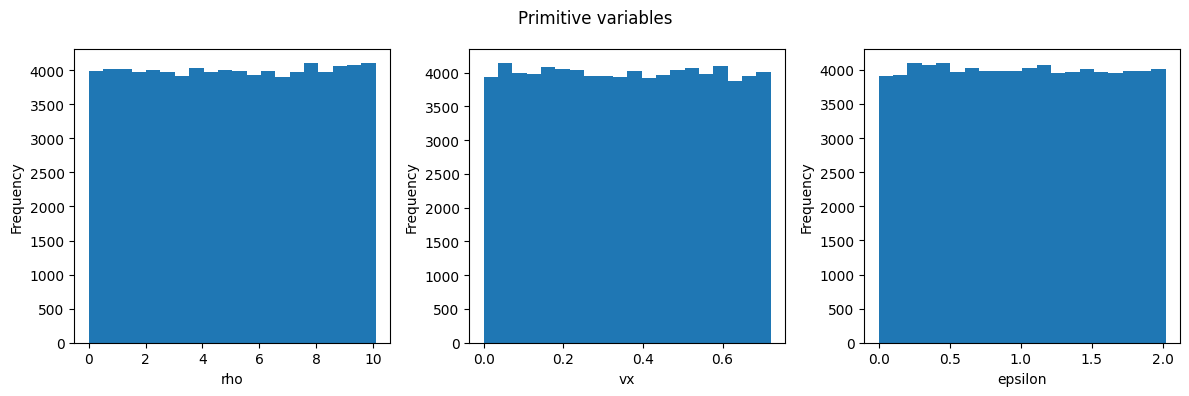

In [ ]:
# Plotting the histograms of rho, vx and epsilon
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(rho_train, bins=20)
plt.xlabel("rho")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(vx_train, bins=20)
plt.xlabel("vx")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(epsilon_train, bins=20)
plt.xlabel("epsilon")
plt.ylabel("Frequency")
#plt.yscale("log")
plt.suptitle("Primitive variables")
plt.tight_layout()
plt.show()



In [ ]:

# Generating the input and output data for train and test sets.
x_train = generate_input_data(rho_train, vx_train, epsilon_train)
y_train = generate_labels(rho_train, epsilon_train) 
x_test = generate_input_data(rho_test, vx_test, epsilon_test) 
y_test = generate_labels(rho_test, epsilon_test) 


tensor([1.3581, 2.3185, 0.5027,  ..., 3.1681, 4.1010, 4.4421], device='cuda:0')

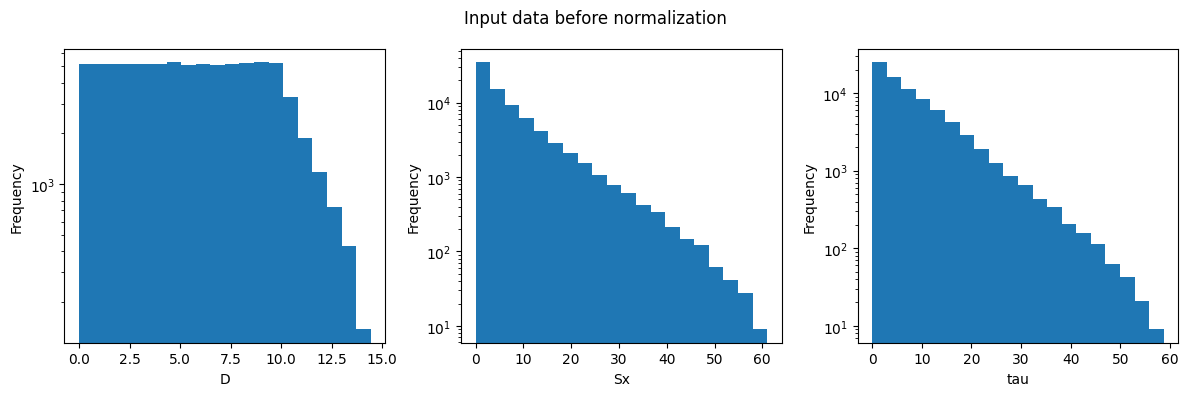

In [ ]:
# Plotting the histograms of the input data before normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data before normalization")
plt.tight_layout()
plt.show()


Perform z-score normalization

In [ ]:
if ZSCORE_NORMALIZATION:
    # Computing the mean and standard deviation of each input variable from the training set
    D_mean = torch.mean(x_train[:, 0])
    D_std = torch.std(x_train[:, 0])
    Sx_mean = torch.mean(x_train[:, 1])
    Sx_std = torch.std(x_train[:, 1])
    tau_mean = torch.mean(x_train[:, 2])
    tau_std = torch.std(x_train[:, 2])

    # Applying z-score normalization to both train and test sets using the statistics from the training set
    x_train[:, 0] = torch.sub(x_train[:, 0], D_mean).div(D_std)
    x_train[:, 1] = torch.sub(x_train[:, 1], Sx_mean).div(Sx_std)
    x_train[:, 2] = torch.sub(x_train[:, 2], tau_mean).div(tau_std)
    x_test[:, 0] = torch.sub(x_test[:, 0], D_mean).div(D_std)
    x_test[:, 1] = torch.sub(x_test[:, 1], Sx_mean).div(Sx_std)
    x_test[:, 2] = torch.sub(x_test[:, 2], tau_mean).div(tau_std)


tensor(5.6566, device='cuda:0')
tensor(3.3397, device='cuda:0')
tensor(6.8964, device='cuda:0')
tensor(8.1582, device='cuda:0')
tensor(8.0618, device='cuda:0')
tensor(7.8985, device='cuda:0')


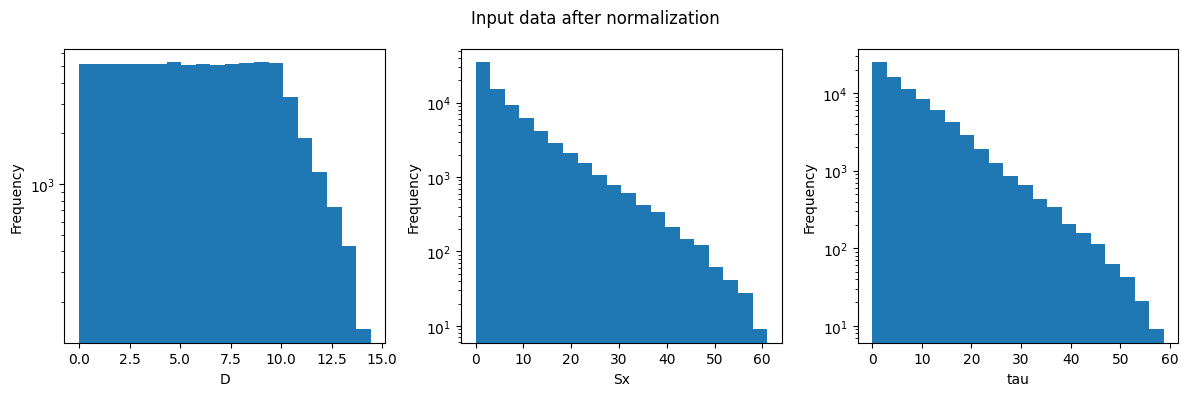

In [ ]:

# Verifying that the means and the stds of the input data are close to 0 and 1 respectively.
print(torch.mean(x_train[:, 0]))
print(torch.std(x_train[:, 0]))
print(torch.mean(x_train[:, 1]))
print(torch.std(x_train[:, 1]))
print(torch.mean(x_train[:, 2]))
print(torch.std(x_train[:, 2]))

# Plotting the histograms of the input data after normalization
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(x_train[:, 0].cpu().numpy(), bins=20)
plt.xlabel("D")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 2)
plt.hist(x_train[:, 1].cpu().numpy(), bins=20)
plt.xlabel("Sx")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 3, 3)
plt.hist(x_train[:, 2].cpu().numpy(), bins=20)
plt.xlabel("tau")
plt.ylabel("Frequency")
plt.yscale("log")
plt.suptitle("Input data after normalization")
plt.tight_layout()
plt.show()


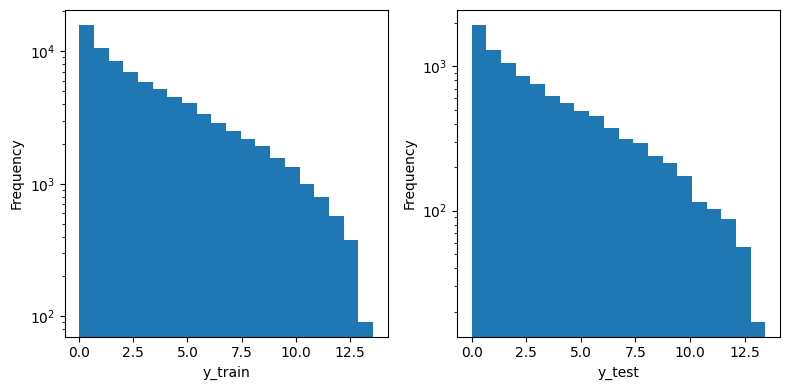

In [ ]:
# Checking if our output is always positive by plotting a histogram of y_train and y_test tensors 
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(y_train.cpu().numpy(), bins=20) # must be cpu here.
plt.xlabel("y_train")
plt.ylabel("Frequency")
plt.yscale("log")
plt.subplot(1, 2, 2)
plt.hist(y_test.cpu().numpy(), bins=20) # must be cpu here
plt.xlabel("y_test")
plt.ylabel("Frequency")
plt.yscale("log")
plt.tight_layout()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Defining the neural network

In [ ]:
# Defining a class for the network
class Net(nn.Module):
    """A class for creating a network with a
    variable number of hidden layers and units.

    Attributes:
        n_layers (int): The number of hidden layers in the network.
        n_units (list): A list of integers representing the number of units in each hidden layer.
        hidden_activation (torch.nn.Module): The activation function for the hidden layers.
        output_activation (torch.nn.Module): The activation function for the output layer.
        layers (torch.nn.ModuleList): A list of linear layers in the network.
    """

    def __init__(self, n_layers, n_units, hidden_activation, output_activation):
        """Initializes the network with the given hyperparameters.

        Args:
            n_layers (int): The number of hidden layers in the network.
            n_units (list): A list of integers representing the number of units in each hidden layer.
            hidden_activation (torch.nn.Module): The activation function for the hidden layers.
            output_activation (torch.nn.Module): The activation function for the output layer.
        """
        super().__init__()
        self.n_layers = n_layers
        self.n_units = n_units
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation

        # Creating a list of linear layers with different numbers of units for each layer
        self.layers = nn.ModuleList([nn.Linear(3, n_units[0])])
        for i in range(1, n_layers):
            self.layers.append(nn.Linear(n_units[i - 1], n_units[i]))
        self.layers.append(nn.Linear(n_units[-1], 1))

        # Adding some assertions to check that the input arguments are valid
        assert isinstance(n_layers, int) and n_layers > 0, "n_layers must be a positive integer"
        assert isinstance(n_units, list) and len(n_units) == n_layers, "n_units must be a list of length n_layers"
        assert all(isinstance(n, int) and n > 0 for n in n_units), "n_units must contain positive integers"
        assert isinstance(hidden_activation, nn.Module), "hidden_activation must be a torch.nn.Module"
        assert isinstance(output_activation, nn.Module), "output_activation must be a torch.nn.Module"

    def forward(self, x):
        """Performs a forward pass on the input tensor.

        Args:
            x (torch.Tensor): The input tensor of shape (batch_size, 3).

        Returns:
            torch.Tensor: The output tensor of shape (batch_size, 1).
        """
        # Looping over the hidden layers and applying the linear transformation and the activation function
        for layer in self.layers[:-1]:
            x = self.hidden_activation(layer(x))
        # Applying the linear transformation and the activation function on the output layer
        x = self.output_activation(self.layers[-1](x))

        # Returning the output tensor
        return x

## Defining the model and search space

In [ ]:
# Defining a function to create a trial network and optimizer
def create_model(trial, optimize):
    """Creates a trial network and optimizer based on the sampled hyperparameters.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.
        optimize (boolean): Whether to optimize the hyperparameters or to use predefined values.

    Returns:
        tuple: A tuple of (net, loss_fn, optimizer, batch_size, n_epochs,
            scheduler, loss_name, optimizer_name, scheduler_name,
            n_units, n_layers, hidden_activation, output_activation),
            where net is the trial network,
            loss_fn is the loss function,
            optimizer is the optimizer,
            batch_size is the batch size,
            n_epochs is the number of epochs,
            scheduler is the learning rate scheduler,
            loss_name is the name of the loss function,
            optimizer_name is the name of the optimizer,
            scheduler_name is the name of the scheduler,
            n_units is a list of integers representing
            the number of units in each hidden layer,
            n_layers is an integer representing the number of hidden layers in the network,
            hidden_activation is a torch.nn.Module representing the activation function for the hidden layers,
            output_activation is a torch.nn.Module representing the activation function for the output layer,
            lr is the (initial) learning rate.
    """
    # If optimize is True, sample the hyperparameters from the search space
    if optimize:
        # Sampling the hyperparameters from the search space
        n_layers = trial.suggest_int("n_layers", 1, 10)
        n_units = [trial.suggest_int(f"n_units_{i}", 16, 1024) for i in range(n_layers)] 
        hidden_activation_name = trial.suggest_categorical(
            "hidden_activation", ["ReLU", "LeakyReLU", "ELU", "Tanh", "Sigmoid"]
        )
        output_activation_name = trial.suggest_categorical(
            #"output_activation", ["Linear", "ReLU", "Softplus"]
            # Assuming pressure cannot be negative, linear output activation is not an option.
            "output_activation", ["ReLU", "Softplus"]
        ) 
        loss_name = trial.suggest_categorical(
            #"loss", ["MSE", "MAE", "Huber", "LogCosh"] 
            "loss", ["MSE", "MAE", "Huber"] 
        )
        optimizer_name = trial.suggest_categorical(
            "optimizer", ["Adam", "SGD", "RMSprop", "Adagrad"] 
        )
        lr = trial.suggest_loguniform("lr", 1e-4, 1e-2) 
        batch_size = trial.suggest_int("batch_size", 16, 512)
        n_epochs = trial.suggest_int("n_epochs", 50, 150) 
        scheduler_name = trial.suggest_categorical(
            "scheduler",
            ["None", "CosineAnnealingLR", "ReduceLROnPlateau", "StepLR", "ExponentialLR"],
        )

    # If optimize is False, use the predefined values
    else:
        # Setting the hyperparameters to the predefined values
        n_layers = N_LAYERS_NO_OPT
        n_units = N_UNITS_NO_OPT
        hidden_activation_name = HIDDEN_ACTIVATION_NAME_NO_OPT
        output_activation_name = OUTPUT_ACTIVATION_NAME_NO_OPT
        loss_name = LOSS_NAME_NO_OPT
        optimizer_name = OPTIMIZER_NAME_NO_OPT
        lr = LR_NO_OPT
        batch_size = BATCH_SIZE_NO_OPT
        n_epochs = N_EPOCHS_NO_OPT
        scheduler_name = SCHEDULER_NAME_NO_OPT


    # Creating the activation functions from their names
    if hidden_activation_name == "ReLU":
        hidden_activation = nn.ReLU()
    elif hidden_activation_name == "LeakyReLU":
        hidden_activation = nn.LeakyReLU() 
    elif hidden_activation_name == "ELU":
        hidden_activation = nn.ELU() 
    elif hidden_activation_name == "Tanh":
        hidden_activation = nn.Tanh()
    else:
        hidden_activation = nn.Sigmoid()

    if output_activation_name == "ReLU":
        output_activation = nn.ReLU()
    elif output_activation_name == "Softplus":
        output_activation = nn.Softplus()
    else:
        output_activation = nn.Identity()

    # Creating the loss function from its name
    if loss_name == "MSE":
        loss_fn = nn.MSELoss()
    elif loss_name == "MAE":
        loss_fn = nn.L1Loss()
    elif loss_name == "Huber":
        loss_fn = nn.SmoothL1Loss() 
    else:
        # Creating the log-cosh loss function
        def log_cosh_loss(y_pred, y_true):
            return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
            
        loss_fn = log_cosh_loss

    # Creating the network with the sampled hyperparameters
    net = Net(
        n_layers, n_units, hidden_activation, output_activation
    ).to(device)

    if optimize:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            # Added sampling the weight decay and momentum for SGD
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            momentum = trial.suggest_uniform("momentum", 0.0, 0.99)
            optimizer = optim.SGD(net.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        elif optimizer_name == "Adam":
            # Added sampling the weight decay and beta parameters for Adam
            weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
            beta1 = trial.suggest_uniform("beta1", 0.5, 0.99)
            beta2 = trial.suggest_uniform("beta2", 0.9, 0.999)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay, betas=(beta1, beta2))
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            # Added sampling the step_size and gamma for StepLR
            step_size = trial.suggest_int("step_size", 5, 15)
            gamma = trial.suggest_uniform("gamma", 0.05, 0.5)
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
        elif scheduler_name == "ExponentialLR":
            # Added sampling the gamma for ExponentialLR
            gamma = trial.suggest_uniform("gamma", 0.8, 0.99)
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
        elif scheduler_name == "CosineAnnealingLR":
            # Added sampling the T_max for CosineAnnealingLR
            T_max = trial.suggest_int("T_max", 5, 15)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added sampling the factor, patience and threshold for ReduceLROnPlateau
            factor = trial.suggest_uniform("factor", 0.1, 0.9)
            patience = trial.suggest_int("patience", 5, 15)
            threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode="min", factor=factor, patience=patience, threshold=threshold
            )
        # # Added using OneCycleLR scheduler as an option
        # elif scheduler_name == "OneCycleLR":
        #         # Added sampling the max_lr and pct_start for OneCycleLR
        #         max_lr = trial.suggest_loguniform("max_lr", lr, 10 * lr) 
        #         pct_start = trial.suggest_uniform("pct_start", 0.1, 0.9)
        #         scheduler = optim.lr_scheduler.OneCycleLR(
        #             optimizer,
        #             max_lr=max_lr,
        #             epochs=n_epochs,
        #             steps_per_epoch=len(train_loader),
        #             pct_start=pct_start,
        #         )
        else:
            scheduler = None
    else:
        # Creating the optimizer from its name
        if optimizer_name == "SGD":
            optimizer = optim.SGD(net.parameters(), lr=lr)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(net.parameters(), lr=lr)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(net.parameters(), lr=lr)
        else:
            # Added creating the Adagrad optimizer
            optimizer = optim.Adagrad(net.parameters(), lr=lr)

        # Creating the learning rate scheduler from its name
        if scheduler_name == "StepLR":
            scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        elif scheduler_name == "ExponentialLR":
            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        elif scheduler_name == "CosineAnnealingLR":
            # Added creating the CosineAnnealingLR scheduler
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
        elif scheduler_name == "ReduceLROnPlateau":
            # Added creating the ReduceLROnPlateau scheduler
            # Creating the ReduceLROnPlateau scheduler with a threshold value of 0.01
            #scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            #    optimizer, mode="min", factor=0.1, patience=10, threshold=0.01
            #)
            # Use Dieseldorst et al. settings and add to that a minimum lr.
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                        optimizer, mode="min", factor=0.5, patience=5, threshold=0.0005, min_lr=1e-6
                    )
        else:
            scheduler = None


    # Returning all variables needed for saving and loading
    return net, loss_fn, optimizer, batch_size, n_epochs, scheduler, loss_name, optimizer_name, scheduler_name, n_units, n_layers, hidden_activation, output_activation, lr



 ## The training and evaluation loop

 We first define a couple of functions used in the training and evaluation.

In [ ]:
# Defining a function that computes loss and metrics for a given batch
def compute_loss_and_metrics(y_pred, y_true, loss_fn):
    """Computes loss and metrics for a given batch.

    Args:
        y_pred (torch.Tensor): The predicted pressure tensor of shape (batch_size, 1).
        y_true (torch.Tensor): The true pressure tensor of shape (batch_size,).
        loss_fn (torch.nn.Module or function): The loss function to use.

    Returns:
        tuple: A tuple of (loss, l1_norm), where loss is a scalar tensor,
            l1_norm is L1 norm for relative error of pressure,
            each being a scalar tensor.
            linf_norm is Linf norm for relative error of pressure.
    """
    # Reshaping the target tensor to match the input tensor
    y_true = y_true.view(-1, 1)

    # Computing the loss using the loss function
    loss = loss_fn(y_pred, y_true)

    # Computing the relative error of pressure
    rel_error = torch.abs((y_pred - y_true) / y_true)

    # Computing the L1 norm for the relative error of pressure
    l1_norm = torch.mean(rel_error) 
    # Computing the Linf norm for the relative error of pressure
    linf_norm = torch.max(rel_error) 

    # Returning the loss and metrics
    return loss, l1_norm, linf_norm


# Defining a function that updates the learning rate scheduler with validation loss if applicable
def update_scheduler(scheduler, test_loss):
    """Updates the learning rate scheduler with validation loss if applicable.

    Args:
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler to use.
        test_loss (float): The validation loss to use.

    Returns:
        None
    """
    # Checking if scheduler is not None
    if scheduler is not None:
        # Checking if scheduler is ReduceLROnPlateau
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            # Updating the scheduler with test_loss
            scheduler.step(test_loss)
        else:
            # Updating the scheduler without test_loss
            scheduler.step()


Now for the actual training and evaluation loop,

In [ ]:
# Defining a function to train and evaluate a network
def train_and_eval(net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial=None):
    """Trains and evaluates a network.

    Args:
        net (torch.nn.Module): The network to train and evaluate.
        loss_fn (torch.nn.Module or function): The loss function.
        optimizer (torch.optim.Optimizer): The optimizer.
        batch_size (int): The batch size.
        n_epochs (int): The number of epochs.
        scheduler (torch.optim.lr_scheduler._LRScheduler or None): The learning rate scheduler.
    Returns:
        tuple: A tuple of (train_losses, test_losses, train_metrics, test_metrics), where
            train_losses is a list of training losses for each epoch,
            test_losses is a list of validation losses for each epoch,
            train_metrics is a list of dictionaries containing training metrics for each epoch,
            test_metrics is a list of dictionaries containing validation metrics for each epoch.
    """
    # Creating data loaders for train and test sets
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size
    )

    # Initializing lists to store the losses and metrics for each epoch
    train_losses = []
    test_losses = []
    train_metrics = []
    test_metrics = []

    # Creating a SummaryWriter object to log data for tensorboard
    writer = tbx.SummaryWriter()

    # Looping over the epochs
    for epoch in range(n_epochs):

        # Setting the network to training mode
        net.train()

        # Initializing variables to store the total loss and metrics for the train set
        train_loss = 0.0
        train_l1_norm = 0.0
        train_linf_norm = 0.0

        # Looping over the batches in the train set
        for x_batch, y_batch in train_loader:

            # Moving the batch tensors to the device
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            # Zeroing the gradients
            optimizer.zero_grad()

            # Performing a forward pass and computing the loss and metrics
            y_pred = net(x_batch)
            loss, l1_norm, linf_norm = compute_loss_and_metrics(
                y_pred, y_batch, loss_fn
            )


            # Performing a backward pass and updating the weights
            loss.backward()
            optimizer.step()

            # Updating the total loss and metrics for the train set
            train_loss += loss.item() * x_batch.size(0)
            train_l1_norm += l1_norm.item() * x_batch.size(0)
            train_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the train set
        train_loss /= len(train_loader.dataset)
        train_l1_norm /= len(train_loader.dataset)
        train_linf_norm /= len(train_loader.dataset)

        # Appending the average loss and metrics for the train set to the lists
        train_losses.append(train_loss)
        train_metrics.append(
            {
                "l1_norm": train_l1_norm,
                "linf_norm": train_linf_norm,
            }
        )

        # Logging the average loss and metrics for the train set to tensorboard
        writer.add_scalar("Loss/train", train_loss, epoch)
        writer.add_scalar("L1 norm/train", train_l1_norm, epoch)
        writer.add_scalar("Linf norm/train", train_linf_norm, epoch)

        # Setting the network to evaluation mode
        net.eval()

        # Initializing variables to store the total loss and metrics for the test set
        test_loss = 0.0
        test_l1_norm = 0.0
        test_linf_norm = 0.0

        # Looping over the batches in the test set
        with torch.no_grad():
            for x_batch, y_batch in test_loader:

                # Moving the batch tensors to the device
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # Performing a forward pass and computing the loss and metrics
                y_pred = net(x_batch)
                loss, l1_norm, linf_norm = compute_loss_and_metrics(
                    y_pred, y_batch, loss_fn
                )


                # Updating the total loss and metrics for the test set
                test_loss += loss.item() * x_batch.size(0)
                test_l1_norm += l1_norm.item() * x_batch.size(0)
                test_linf_norm += linf_norm.item() * x_batch.size(0)

        # Computing the average loss and metrics for the test set
        test_loss /= len(test_loader.dataset)
        test_l1_norm /= len(test_loader.dataset)
        test_linf_norm /= len(test_loader.dataset)

        # Appending the average loss and metrics for the test set to the lists
        test_losses.append(test_loss)
        test_metrics.append(
            {
                "l1_norm": test_l1_norm,
                "linf_norm": test_linf_norm,
            }
        )

        # Logging the average loss and metrics for the test set to tensorboard
        writer.add_scalar("Loss/test", test_loss, epoch)
        writer.add_scalar("L1 norm/test", test_l1_norm, epoch)
        writer.add_scalar("Linf norm/test", test_linf_norm, epoch)

        # Printing the average loss and metrics for both sets for this epoch
        print(
            f"Epoch {epoch + 1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, "
            f"Train L1 Norm: {train_l1_norm:.4f}, Test L1 Norm: {test_l1_norm:.4f}, "
            f"Train Linf Norm: {train_linf_norm:.4f}, Test Linf Norm: {test_linf_norm:.4f}"
        )

        # Updating the learning rate scheduler with validation loss if applicable
        update_scheduler(scheduler, test_loss)

        # Reporting the intermediate metric value to Optuna if trial is not None
        if trial is not None:
            trial.report(test_metrics[-1]["l1_norm"], epoch)

            # Checking if the trial should be pruned based on the intermediate value if trial is not None
            if trial.should_prune():
                raise optuna.TrialPruned()

    # Closing the SummaryWriter object
    writer.close()

    # Returning the losses and metrics lists
    return train_losses, test_losses, train_metrics, test_metrics

## The objective function and hyperparameter tuning

In [ ]:
# Defining an objective function for Optuna to minimize
def objective(trial):
    """Defines an objective function for Optuna to minimize.

    Args:
        trial (optuna.trial.Trial): The trial object that contains the hyperparameters.

    Returns:
        float: The validation L1 norm to minimize.
    """
    # Creating a trial network and optimizer using the create_model function
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)

    # Training and evaluating the network using the train_and_eval function
    _, _, _, test_metrics = train_and_eval(
        net, loss_fn, optimizer, batch_size, n_epochs, scheduler, trial
    )

    # Returning the last validation L1 norm as the objective value to minimize
    return test_metrics[-1]["l1_norm"]

In [ ]:
if OPTIMIZE:
    # Creating a study object with Optuna with TPE sampler and median pruner 
    study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.MedianPruner())

    # Running Optuna with 100 trials when we are optimizing.
    study.optimize(objective, n_trials=N_TRIALS)

    # Printing the best trial information
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")


[I 2023-05-15 20:26:27,579] A new study created in memory with name: no-name-227d8cf9-3b19-4e63-90a7-bbc7a092daa1
<ipython-input-38-9db69549bfa5>:49: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
<ipython-input-38-9db69549bfa5>:114: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-38-9db69549bfa5>:115: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  mom

Epoch 1: Train Loss: 20.6582, Test Loss: 20.9920, Train L1 Norm: 2.6967, Test L1 Norm: 1.5123, Train Linf Norm: 33.2441, Test Linf Norm: 10.4531
Epoch 2: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 2.6662, Test L1 Norm: 1.5049, Train Linf Norm: 32.7417, Test Linf Norm: 10.3184
Epoch 3: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 2.6504, Test L1 Norm: 1.4998, Train Linf Norm: 32.4402, Test Linf Norm: 10.2249
Epoch 4: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 2.6347, Test L1 Norm: 1.4971, Train Linf Norm: 32.1248, Test Linf Norm: 10.1763
Epoch 5: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 2.6298, Test L1 Norm: 1.4963, Train Linf Norm: 32.0185, Test Linf Norm: 10.1623
Epoch 6: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 2.6288, Test L1 Norm: 1.4963, Train Linf Norm: 32.0363, Test Linf Norm: 10.1623
Epoch 7: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 2.6274, Test L1 Norm: 1.4956, Train Linf Norm: 31.9713, Test Linf

[I 2023-05-15 20:36:41,720] Trial 0 finished with value: 1.3581803245186805 and parameters: {'n_layers': 1, 'n_units_0': 208, 'hidden_activation': 'ELU', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'SGD', 'lr': 0.0024619873136192964, 'batch_size': 19, 'n_epochs': 92, 'scheduler': 'CosineAnnealingLR', 'weight_decay': 1.2557787103869473e-05, 'momentum': 0.060027615847505184, 'T_max': 5}. Best is trial 0 with value: 1.3581803245186805.


Epoch 92: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 2.1881, Test L1 Norm: 1.3582, Train Linf Norm: 23.6578, Test Linf Norm: 7.6431
Epoch 1: Train Loss: 10.2310, Test Loss: 10.7296, Train L1 Norm: 49.3703, Test L1 Norm: 33.3204, Train Linf Norm: 2240.2827, Test Linf Norm: 1300.2364
Epoch 2: Train Loss: 9.4597, Test Loss: 9.9445, Train L1 Norm: 54.7585, Test L1 Norm: 17.9618, Train Linf Norm: 2502.1190, Test Linf Norm: 703.6359
Epoch 3: Train Loss: 9.3353, Test Loss: 9.1418, Train L1 Norm: 47.8564, Test L1 Norm: 24.2617, Train Linf Norm: 2165.8962, Test Linf Norm: 949.5938
Epoch 4: Train Loss: 9.2140, Test Loss: 9.1662, Train L1 Norm: 51.1026, Test L1 Norm: 23.2002, Train Linf Norm: 2325.3516, Test Linf Norm: 908.3065
Epoch 5: Train Loss: 9.1005, Test Loss: 9.1716, Train L1 Norm: 50.2372, Test L1 Norm: 23.0838, Train Linf Norm: 2255.6728, Test Linf Norm: 903.7722
Epoch 6: Train Loss: 9.0526, Test Loss: 9.1557, Train L1 Norm: 51.4127, Test L1 Norm: 25.1539, Train Linf Norm: 

[I 2023-05-15 20:49:33,783] Trial 1 finished with value: 20.297947662472726 and parameters: {'n_layers': 7, 'n_units_0': 204, 'n_units_1': 590, 'n_units_2': 554, 'n_units_3': 759, 'n_units_4': 947, 'n_units_5': 259, 'n_units_6': 645, 'hidden_activation': 'Sigmoid', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.008681642058913074, 'batch_size': 50, 'n_epochs': 132, 'scheduler': 'CosineAnnealingLR', 'T_max': 6}. Best is trial 0 with value: 1.3581803245186805.


Epoch 132: Train Loss: 9.4420, Test Loss: 9.4613, Train L1 Norm: 50.5632, Test L1 Norm: 20.2979, Train Linf Norm: 2298.3725, Test Linf Norm: 795.1222


<ipython-input-38-9db69549bfa5>:137: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  gamma = trial.suggest_uniform("gamma", 0.8, 0.99)


Epoch 1: Train Loss: 2.4711, Test Loss: 0.7119, Train L1 Norm: 0.6106, Test L1 Norm: 0.4210, Train Linf Norm: 24.5301, Test Linf Norm: 13.6703
Epoch 2: Train Loss: 0.8188, Test Loss: 0.7647, Train L1 Norm: 0.5092, Test L1 Norm: 0.4309, Train Linf Norm: 29.3891, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 0.6341, Test Loss: 0.2387, Train L1 Norm: 0.4481, Test L1 Norm: 0.3161, Train Linf Norm: 26.0050, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 0.5994, Test Loss: 0.3182, Train L1 Norm: 0.4903, Test L1 Norm: 0.2636, Train Linf Norm: 57.7998, Test Linf Norm: 1.5604
Epoch 5: Train Loss: 0.5104, Test Loss: 0.4066, Train L1 Norm: 0.4705, Test L1 Norm: 0.3485, Train Linf Norm: 63.2368, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 0.4770, Test Loss: 0.8083, Train L1 Norm: 0.4039, Test L1 Norm: 0.3531, Train Linf Norm: 38.0249, Test Linf Norm: 1.6999
Epoch 7: Train Loss: 0.4261, Test Loss: 0.7249, Train L1 Norm: 0.3492, Test L1 Norm: 0.3700, Train Linf Norm: 15.1120, Test Linf Norm: 1.0000
Epoch

[I 2023-05-15 20:51:42,367] Trial 2 finished with value: 0.08990541520118714 and parameters: {'n_layers': 1, 'n_units_0': 450, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.00500937511508636, 'batch_size': 502, 'n_epochs': 128, 'scheduler': 'ExponentialLR', 'gamma': 0.9825178253612334}. Best is trial 2 with value: 0.08990541520118714.


Epoch 128: Train Loss: 0.0031, Test Loss: 0.0037, Train L1 Norm: 0.0700, Test L1 Norm: 0.0899, Train Linf Norm: 6.3054, Test Linf Norm: 1.5293
Epoch 1: Train Loss: 1.9756, Test Loss: 1.9301, Train L1 Norm: 32.3695, Test L1 Norm: 18.0582, Train Linf Norm: 9200.3999, Test Linf Norm: 4042.4476
Epoch 2: Train Loss: 1.9077, Test Loss: 1.9291, Train L1 Norm: 39.2227, Test L1 Norm: 18.0128, Train Linf Norm: 11194.7250, Test Linf Norm: 4032.2332
Epoch 3: Train Loss: 1.9067, Test Loss: 1.9281, Train L1 Norm: 39.5528, Test L1 Norm: 17.9700, Train Linf Norm: 9193.9636, Test Linf Norm: 4022.5767
Epoch 4: Train Loss: 1.9057, Test Loss: 1.9268, Train L1 Norm: 39.1201, Test L1 Norm: 18.1503, Train Linf Norm: 11235.1885, Test Linf Norm: 4062.8862
Epoch 5: Train Loss: 1.9047, Test Loss: 1.9257, Train L1 Norm: 39.1058, Test L1 Norm: 18.1639, Train Linf Norm: 11136.3407, Test Linf Norm: 4065.8757
Epoch 6: Train Loss: 1.9036, Test Loss: 1.9247, Train L1 Norm: 39.2955, Test L1 Norm: 18.0801, Train Linf Nor

[I 2023-05-15 20:54:58,504] Trial 3 finished with value: 0.34738596806526184 and parameters: {'n_layers': 3, 'n_units_0': 561, 'n_units_1': 751, 'n_units_2': 710, 'hidden_activation': 'Sigmoid', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'SGD', 'lr': 0.00038060977413598705, 'batch_size': 342, 'n_epochs': 150, 'scheduler': 'None', 'weight_decay': 0.003270304115431246, 'momentum': 0.2883418260767501}. Best is trial 2 with value: 0.08990541520118714.


Epoch 150: Train Loss: 0.2710, Test Loss: 0.2710, Train L1 Norm: 0.3516, Test L1 Norm: 0.3474, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 5.8544, Test Loss: 3.4424, Train L1 Norm: 2.8781, Test L1 Norm: 1.0000, Train Linf Norm: 196.8172, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 7: 

[I 2023-05-15 20:57:20,939] Trial 4 finished with value: 0.9999999405443668 and parameters: {'n_layers': 2, 'n_units_0': 616, 'n_units_1': 849, 'hidden_activation': 'ELU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0038946807148714413, 'batch_size': 475, 'n_epochs': 120, 'scheduler': 'ExponentialLR', 'gamma': 0.820623295947823}. Best is trial 2 with value: 0.08990541520118714.


Epoch 120: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


<ipython-input-38-9db69549bfa5>:145: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  factor = trial.suggest_uniform("factor", 0.1, 0.9)
<ipython-input-38-9db69549bfa5>:147: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  threshold = trial.suggest_loguniform("threshold", 1e-4, 1e-2)


Epoch 1: Train Loss: 2.9567, Test Loss: 2.9953, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 2.9567, Test Loss: 2.9953, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 2.9567, Test Loss: 2.9953, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 2.9567, Test Loss: 2.9953, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 2.9567, Test Loss: 2.9953, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 2.9567, Test Loss: 2.9953, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 7: Train Loss: 2.9567, Test Loss: 2.9953, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 8: Trai

[I 2023-05-15 21:02:16,824] Trial 5 pruned. 


Epoch 102: Train Loss: 2.9567, Test Loss: 2.9953, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 21:02:20,599] Trial 6 pruned. 


Epoch 1: Train Loss: 1.5796, Test Loss: 0.5552, Train L1 Norm: 37.2183, Test L1 Norm: 7.3425, Train Linf Norm: 3798.7778, Test Linf Norm: 617.9904
Epoch 1: Train Loss: 3.8735, Test Loss: 3.4424, Train L1 Norm: 1.3309, Test L1 Norm: 1.0000, Train Linf Norm: 12.5158, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 3: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 

[I 2023-05-15 21:05:44,642] Trial 7 pruned. 


Epoch 102: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2232, Test Loss: 0.0052, Train L1 Norm: 3.2605, Test L1 Norm: 1.0025, Train Linf Norm: 723.0508, Test Linf Norm: 172.7226
Epoch 2: Train Loss: 0.0037, Test Loss: 0.0024, Train L1 Norm: 1.6555, Test L1 Norm: 0.7318, Train Linf Norm: 379.3807, Test Linf Norm: 129.1155
Epoch 3: Train Loss: 0.0025, Test Loss: 0.0011, Train L1 Norm: 1.4250, Test L1 Norm: 0.6078, Train Linf Norm: 335.1041, Test Linf Norm: 108.7098
Epoch 4: Train Loss: 0.0011, Test Loss: 0.0007, Train L1 Norm: 1.1476, Test L1 Norm: 0.5313, Train Linf Norm: 264.2253, Test Linf Norm: 95.6902
Epoch 5: Train Loss: 0.0008, Test Loss: 0.0006, Train L1 Norm: 1.0528, Test L1 Norm: 0.4803, Train Linf Norm: 246.0702, Test Linf Norm: 86.9556
Epoch 6: Train Loss: 0.0007, Test Loss: 0.0005, Train L1 Norm: 0.9453, Test L1 Norm: 0.4377, Train Linf Norm: 222.8977, Test Linf Norm

[I 2023-05-15 21:08:00,830] Trial 8 finished with value: 0.14879853665158152 and parameters: {'n_layers': 4, 'n_units_0': 220, 'n_units_1': 515, 'n_units_2': 858, 'n_units_3': 826, 'hidden_activation': 'ReLU', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'Adagrad', 'lr': 0.0004321379756035497, 'batch_size': 269, 'n_epochs': 81, 'scheduler': 'None'}. Best is trial 2 with value: 0.08990541520118714.


Epoch 81: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.3105, Test L1 Norm: 0.1488, Train Linf Norm: 75.2229, Test Linf Norm: 29.1079


<ipython-input-38-9db69549bfa5>:119: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
<ipython-input-38-9db69549bfa5>:120: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta1 = trial.suggest_uniform("beta1", 0.5, 0.99)
<ipython-input-38-9db69549bfa5>:121: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  beta2 = trial.suggest_uniform("beta2", 0.9, 0.999)
<ipython-input-38-9db69549bfa5>:133: FutureWarning: suggest_unifor

Epoch 1: Train Loss: 2.3322, Test Loss: 0.0053, Train L1 Norm: 1.8607, Test L1 Norm: 0.5870, Train Linf Norm: 556.1430, Test Linf Norm: 160.3662
Epoch 2: Train Loss: 0.0228, Test Loss: 0.0019, Train L1 Norm: 1.4532, Test L1 Norm: 0.6493, Train Linf Norm: 489.1616, Test Linf Norm: 179.6295
Epoch 3: Train Loss: 0.0148, Test Loss: 0.0432, Train L1 Norm: 1.3859, Test L1 Norm: 0.5429, Train Linf Norm: 463.7513, Test Linf Norm: 140.4162
Epoch 4: Train Loss: 0.0136, Test Loss: 0.0047, Train L1 Norm: 1.3302, Test L1 Norm: 0.6078, Train Linf Norm: 449.3226, Test Linf Norm: 166.8751
Epoch 5: Train Loss: 0.0121, Test Loss: 0.0031, Train L1 Norm: 1.3882, Test L1 Norm: 0.5743, Train Linf Norm: 467.0815, Test Linf Norm: 159.4488
Epoch 6: Train Loss: 0.0100, Test Loss: 0.0051, Train L1 Norm: 1.4179, Test L1 Norm: 0.6192, Train Linf Norm: 481.5459, Test Linf Norm: 172.4267
Epoch 7: Train Loss: 0.0098, Test Loss: 0.0108, Train L1 Norm: 1.4717, Test L1 Norm: 0.6996, Train Linf Norm: 501.0718, Test Linf 

[I 2023-05-15 21:10:24,598] Trial 9 finished with value: 0.5984155371356755 and parameters: {'n_layers': 3, 'n_units_0': 320, 'n_units_1': 879, 'n_units_2': 291, 'hidden_activation': 'ReLU', 'output_activation': 'Softplus', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.00420282461243209, 'batch_size': 385, 'n_epochs': 107, 'scheduler': 'StepLR', 'weight_decay': 0.00047128538130107085, 'beta1': 0.8714583752737218, 'beta2': 0.9453171092748265, 'step_size': 10, 'gamma': 0.3630426209781594}. Best is trial 2 with value: 0.08990541520118714.


Epoch 107: Train Loss: 0.0003, Test Loss: 0.0003, Train L1 Norm: 1.4083, Test L1 Norm: 0.5984, Train Linf Norm: 482.8541, Test Linf Norm: 167.9732
Epoch 1: Train Loss: 2.0056, Test Loss: 0.5551, Train L1 Norm: 24.8115, Test L1 Norm: 0.4468, Train Linf Norm: 11626.0772, Test Linf Norm: 28.5874
Epoch 2: Train Loss: 0.5585, Test Loss: 0.2397, Train L1 Norm: 3.7201, Test L1 Norm: 0.9820, Train Linf Norm: 1516.9516, Test Linf Norm: 288.8101
Epoch 3: Train Loss: 0.4102, Test Loss: 0.3678, Train L1 Norm: 2.4644, Test L1 Norm: 0.3989, Train Linf Norm: 1000.6439, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 0.3170, Test Loss: 0.3194, Train L1 Norm: 0.5083, Test L1 Norm: 0.7633, Train Linf Norm: 77.7127, Test Linf Norm: 200.3841
Epoch 5: Train Loss: 0.2874, Test Loss: 0.1149, Train L1 Norm: 0.9328, Test L1 Norm: 0.2575, Train Linf Norm: 289.9870, Test Linf Norm: 3.2612
Epoch 6: Train Loss: 0.2459, Test Loss: 0.3400, Train L1 Norm: 0.7828, Test L1 Norm: 0.4545, Train Linf Norm: 225.2530, Test Linf

[I 2023-05-15 21:11:45,966] Trial 10 finished with value: 0.12560796790122986 and parameters: {'n_layers': 10, 'n_units_0': 897, 'n_units_1': 56, 'n_units_2': 50, 'n_units_3': 213, 'n_units_4': 116, 'n_units_5': 1022, 'n_units_6': 55, 'n_units_7': 744, 'n_units_8': 990, 'n_units_9': 719, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.0001187576221750296, 'batch_size': 492, 'n_epochs': 56, 'scheduler': 'ExponentialLR', 'gamma': 0.9848883124720255}. Best is trial 2 with value: 0.08990541520118714.


Epoch 56: Train Loss: 0.0208, Test Loss: 0.0357, Train L1 Norm: 0.3885, Test L1 Norm: 0.1256, Train Linf Norm: 123.3854, Test Linf Norm: 2.5084
Epoch 1: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 21:11:48,639] Trial 11 pruned. 


Epoch 2: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 20.5593, Test Loss: 20.9920, Train L1 Norm: 1.0427, Test L1 Norm: 1.0000, Train Linf Norm: 6.8161, Test Linf Norm: 1.0000


[I 2023-05-15 21:11:51,550] Trial 12 pruned. 


Epoch 2: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 2.4729, Test Loss: 1.5591, Train L1 Norm: 0.7238, Test L1 Norm: 0.6090, Train Linf Norm: 34.2445, Test Linf Norm: 29.7096
Epoch 2: Train Loss: 1.2127, Test Loss: 0.9455, Train L1 Norm: 0.4810, Test L1 Norm: 0.4802, Train Linf Norm: 2.3044, Test Linf Norm: 19.8620
Epoch 3: Train Loss: 0.9882, Test Loss: 0.7896, Train L1 Norm: 0.4537, Test L1 Norm: 0.4916, Train Linf Norm: 6.6465, Test Linf Norm: 44.0409
Epoch 4: Train Loss: 0.8312, Test Loss: 1.2770, Train L1 Norm: 0.4704, Test L1 Norm: 0.3930, Train Linf Norm: 27.1387, Test Linf Norm: 1.0152
Epoch 5: Train Loss: 0.7004, Test Loss: 0.6015, Train L1 Norm: 2.1923, Test L1 Norm: 0.4748, Train Linf Norm: 857.2523, Test Linf Norm: 62.6352
Epoch 6: Train Loss: 0.6222, Test Loss: 0.9236, Train L1 Norm: 1.5107, Test L1 Norm: 2.0815, Train Linf Norm: 552.0311, Test Linf Norm: 567.1464

[I 2023-05-15 21:13:22,176] Trial 13 finished with value: 0.19964561028704048 and parameters: {'n_layers': 7, 'n_units_0': 34, 'n_units_1': 311, 'n_units_2': 258, 'n_units_3': 309, 'n_units_4': 413, 'n_units_5': 704, 'n_units_6': 363, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'RMSprop', 'lr': 0.00011093923763539758, 'batch_size': 509, 'n_epochs': 68, 'scheduler': 'ExponentialLR', 'gamma': 0.9809950848185749}. Best is trial 2 with value: 0.08990541520118714.


Epoch 68: Train Loss: 0.0260, Test Loss: 0.0233, Train L1 Norm: 0.5498, Test L1 Norm: 0.1996, Train Linf Norm: 194.7297, Test Linf Norm: 51.5006


[I 2023-05-15 21:13:24,219] Trial 14 pruned. 


Epoch 1: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.9994, Test Loss: 0.8864, Train L1 Norm: 0.5883, Test L1 Norm: 0.4034, Train Linf Norm: 13.8012, Test Linf Norm: 1.8715
Epoch 2: Train Loss: 0.5543, Test Loss: 0.5303, Train L1 Norm: 0.3509, Test L1 Norm: 0.2946, Train Linf Norm: 5.9753, Test Linf Norm: 1.1528
Epoch 3: Train Loss: 0.4616, Test Loss: 0.3882, Train L1 Norm: 0.3104, Test L1 Norm: 0.3092, Train Linf Norm: 6.2749, Test Linf Norm: 3.2566
Epoch 4: Train Loss: 0.4121, Test Loss: 0.4681, Train L1 Norm: 0.3255, Test L1 Norm: 0.3562, Train Linf Norm: 23.8646, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 0.3803, Test Loss: 0.4468, Train L1 Norm: 0.2836, Test L1 Norm: 0.2120, Train Linf Norm: 11.4821, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 0.3597, Test Loss: 0.4142, Train L1 Norm: 0.2556, Test L1 Norm: 0.3545, Train Linf Norm: 5.6938, Test Linf Norm: 19.4002
Epoch 7

[I 2023-05-15 21:16:03,491] Trial 15 finished with value: 0.014171979705290869 and parameters: {'n_layers': 5, 'n_units_0': 784, 'n_units_1': 352, 'n_units_2': 207, 'n_units_3': 406, 'n_units_4': 887, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.00019962451850288527, 'batch_size': 421, 'n_epochs': 116, 'scheduler': 'StepLR', 'step_size': 15, 'gamma': 0.4711798176327334}. Best is trial 15 with value: 0.014171979705290869.


Epoch 116: Train Loss: 0.0055, Test Loss: 0.0063, Train L1 Norm: 0.0141, Test L1 Norm: 0.0142, Train Linf Norm: 0.9683, Test Linf Norm: 1.1756


[I 2023-05-15 21:16:04,900] Trial 16 pruned. 


Epoch 1: Train Loss: 3.9889, Test Loss: 3.4424, Train L1 Norm: 1.4089, Test L1 Norm: 1.0000, Train Linf Norm: 21.5625, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.9582, Test Loss: 0.6265, Train L1 Norm: 0.8647, Test L1 Norm: 0.4992, Train Linf Norm: 143.3697, Test Linf Norm: 60.8907
Epoch 2: Train Loss: 0.5205, Test Loss: 0.4504, Train L1 Norm: 0.3808, Test L1 Norm: 0.3899, Train Linf Norm: 22.8834, Test Linf Norm: 26.8174
Epoch 3: Train Loss: 0.3987, Test Loss: 0.3524, Train L1 Norm: 0.3546, Test L1 Norm: 0.4060, Train Linf Norm: 22.2741, Test Linf Norm: 47.7126
Epoch 4: Train Loss: 0.3022, Test Loss: 0.2527, Train L1 Norm: 0.2850, Test L1 Norm: 0.2589, Train Linf Norm: 18.2451, Test Linf Norm: 22.9758
Epoch 5: Train Loss: 0.2133, Test Loss: 0.1837, Train L1 Norm: 0.2504, Test L1 Norm: 0.2549, Train Linf Norm: 30.5721, Test Linf Norm: 37.2698
Epoch 6: Train Loss: 0.1691, Test Loss: 0.1619, Train L1 Norm: 0.1983, Test L1 Norm: 0.2965, Train Linf Norm: 20.4428, Test Linf Norm: 50.5462

[I 2023-05-15 21:18:38,739] Trial 17 finished with value: 0.09509574236869812 and parameters: {'n_layers': 1, 'n_units_0': 459, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.00023595392045911698, 'batch_size': 368, 'n_epochs': 136, 'scheduler': 'StepLR', 'step_size': 15, 'gamma': 0.18560666510831375}. Best is trial 15 with value: 0.014171979705290869.


Epoch 136: Train Loss: 0.0509, Test Loss: 0.0527, Train L1 Norm: 0.0816, Test L1 Norm: 0.0951, Train Linf Norm: 3.8909, Test Linf Norm: 6.7196
Epoch 1: Train Loss: 0.9855, Test Loss: 0.4284, Train L1 Norm: 0.8291, Test L1 Norm: 0.3483, Train Linf Norm: 83.4329, Test Linf Norm: 49.7580
Epoch 2: Train Loss: 0.2623, Test Loss: 0.1711, Train L1 Norm: 0.3164, Test L1 Norm: 0.1349, Train Linf Norm: 50.9742, Test Linf Norm: 18.0588
Epoch 3: Train Loss: 0.1457, Test Loss: 0.1035, Train L1 Norm: 0.2262, Test L1 Norm: 0.2431, Train Linf Norm: 37.2344, Test Linf Norm: 38.0502
Epoch 4: Train Loss: 0.1015, Test Loss: 0.0782, Train L1 Norm: 0.2466, Test L1 Norm: 0.1229, Train Linf Norm: 44.2533, Test Linf Norm: 19.7101
Epoch 5: Train Loss: 0.0790, Test Loss: 0.1123, Train L1 Norm: 0.1980, Test L1 Norm: 0.0933, Train Linf Norm: 34.0360, Test Linf Norm: 10.0603
Epoch 6: Train Loss: 0.0819, Test Loss: 0.0742, Train L1 Norm: 0.2301, Test L1 Norm: 0.1091, Train Linf Norm: 39.0848, Test Linf Norm: 15.0030

[I 2023-05-15 21:22:25,095] Trial 18 finished with value: 0.06384478420368396 and parameters: {'n_layers': 6, 'n_units_0': 715, 'n_units_1': 401, 'n_units_2': 468, 'n_units_3': 687, 'n_units_4': 774, 'n_units_5': 56, 'hidden_activation': 'Tanh', 'output_activation': 'Softplus', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.00020098408030805992, 'batch_size': 225, 'n_epochs': 115, 'scheduler': 'StepLR', 'weight_decay': 0.00012244312053109424, 'beta1': 0.9761582149829565, 'beta2': 0.9072219290909381, 'step_size': 6, 'gamma': 0.4012201237585521}. Best is trial 15 with value: 0.014171979705290869.


Epoch 115: Train Loss: 0.0107, Test Loss: 0.0113, Train L1 Norm: 0.1130, Test L1 Norm: 0.0638, Train Linf Norm: 22.5083, Test Linf Norm: 11.6726
Epoch 1: Train Loss: 0.6100, Test Loss: 0.1570, Train L1 Norm: 0.7670, Test L1 Norm: 0.3133, Train Linf Norm: 73.7089, Test Linf Norm: 39.5445
Epoch 2: Train Loss: 0.0956, Test Loss: 0.0630, Train L1 Norm: 0.3586, Test L1 Norm: 0.2473, Train Linf Norm: 50.5607, Test Linf Norm: 34.2205
Epoch 3: Train Loss: 0.0563, Test Loss: 0.0575, Train L1 Norm: 0.2133, Test L1 Norm: 0.2629, Train Linf Norm: 28.8888, Test Linf Norm: 35.7135
Epoch 4: Train Loss: 0.0632, Test Loss: 0.0727, Train L1 Norm: 0.2406, Test L1 Norm: 0.1341, Train Linf Norm: 34.3728, Test Linf Norm: 15.2011
Epoch 5: Train Loss: 0.0500, Test Loss: 0.0679, Train L1 Norm: 0.2047, Test L1 Norm: 0.2442, Train Linf Norm: 29.3314, Test Linf Norm: 32.3597
Epoch 6: Train Loss: 0.0334, Test Loss: 0.0312, Train L1 Norm: 0.1982, Test L1 Norm: 0.1472, Train Linf Norm: 30.4036, Test Linf Norm: 20.51

[I 2023-05-15 21:25:57,949] Trial 19 finished with value: 0.09597998101008125 and parameters: {'n_layers': 6, 'n_units_0': 711, 'n_units_1': 351, 'n_units_2': 475, 'n_units_3': 663, 'n_units_4': 724, 'n_units_5': 170, 'hidden_activation': 'Tanh', 'output_activation': 'Softplus', 'loss': 'MAE', 'optimizer': 'Adam', 'lr': 0.0001900333524933782, 'batch_size': 185, 'n_epochs': 94, 'scheduler': 'StepLR', 'weight_decay': 0.0001328408796407634, 'beta1': 0.9765855338153296, 'beta2': 0.9007708132656647, 'step_size': 5, 'gamma': 0.4045161052300896}. Best is trial 15 with value: 0.014171979705290869.


Epoch 94: Train Loss: 0.0052, Test Loss: 0.0053, Train L1 Norm: 0.1703, Test L1 Norm: 0.0960, Train Linf Norm: 28.0982, Test Linf Norm: 14.5065


[I 2023-05-15 21:26:01,187] Trial 20 pruned. 


Epoch 1: Train Loss: 0.2749, Test Loss: 0.2088, Train L1 Norm: 4.9329, Test L1 Norm: 0.8162, Train Linf Norm: 895.6234, Test Linf Norm: 113.8610


[I 2023-05-15 21:26:02,458] Trial 21 pruned. 


Epoch 1: Train Loss: 0.6750, Test Loss: 0.2120, Train L1 Norm: 1.8823, Test L1 Norm: 0.7376, Train Linf Norm: 574.7427, Test Linf Norm: 192.2597


[I 2023-05-15 21:26:04,291] Trial 22 pruned. 


Epoch 1: Train Loss: 0.6114, Test Loss: 0.3956, Train L1 Norm: 0.8791, Test L1 Norm: 0.9223, Train Linf Norm: 138.9785, Test Linf Norm: 132.6380
Epoch 1: Train Loss: 0.5455, Test Loss: 0.3967, Train L1 Norm: 0.7069, Test L1 Norm: 0.4232, Train Linf Norm: 61.5055, Test Linf Norm: 32.3406
Epoch 2: Train Loss: 0.2973, Test Loss: 0.3457, Train L1 Norm: 0.7847, Test L1 Norm: 0.5663, Train Linf Norm: 90.6590, Test Linf Norm: 54.9317
Epoch 3: Train Loss: 0.2532, Test Loss: 0.2310, Train L1 Norm: 0.6951, Test L1 Norm: 0.5262, Train Linf Norm: 80.5870, Test Linf Norm: 55.6423
Epoch 4: Train Loss: 0.2297, Test Loss: 0.1935, Train L1 Norm: 0.6330, Test L1 Norm: 0.4512, Train Linf Norm: 73.4212, Test Linf Norm: 45.8225
Epoch 5: Train Loss: 0.2109, Test Loss: 0.2064, Train L1 Norm: 0.5389, Test L1 Norm: 0.3118, Train Linf Norm: 61.4674, Test Linf Norm: 31.2362
Epoch 6: Train Loss: 0.1959, Test Loss: 0.2182, Train L1 Norm: 0.4690, Test L1 Norm: 0.3058, Train Linf Norm: 52.3794, Test Linf Norm: 29.20

[I 2023-05-15 21:29:06,167] Trial 23 pruned. 


Epoch 93: Train Loss: 0.0050, Test Loss: 0.0050, Train L1 Norm: 0.2427, Test L1 Norm: 0.1451, Train Linf Norm: 32.7808, Test Linf Norm: 18.3033


[I 2023-05-15 21:29:07,966] Trial 24 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.5110, Test Loss: 0.0365, Train L1 Norm: 4.4324, Test L1 Norm: 0.1907, Train Linf Norm: 1494.2690, Test Linf Norm: 7.3747
Epoch 2: Train Loss: 0.0226, Test Loss: 0.0119, Train L1 Norm: 0.1742, Test L1 Norm: 0.3353, Train Linf Norm: 6.9465, Test Linf Norm: 81.0464
Epoch 3: Train Loss: 0.0127, Test Loss: 0.0068, Train L1 Norm: 0.1685, Test L1 Norm: 0.1245, Train Linf Norm: 16.9555, Test Linf Norm: 2.3040
Epoch 4: Train Loss: 0.0113, Test Loss: 0.0183, Train L1 Norm: 0.1402, Test L1 Norm: 0.2936, Train Linf Norm: 8.6862, Test Linf Norm: 66.6036
Epoch 5: Train Loss: 0.0090, Test Loss: 0.0038, Train L1 Norm: 0.1618, Test L1 Norm: 0.1205, Train Linf Norm: 24.5524, Test Linf Norm: 16.3697
Epoch 6: Train Loss: 0.0077, Test Loss: 0.0131, Train L1 Norm: 0.1223, Test L1 Norm: 0.1120, Train Linf Norm: 7.1479, Test Linf Norm: 9.5183
Epoch

[I 2023-05-15 21:31:44,170] Trial 25 finished with value: 0.11590723605006933 and parameters: {'n_layers': 5, 'n_units_0': 700, 'n_units_1': 503, 'n_units_2': 647, 'n_units_3': 185, 'n_units_4': 997, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'Huber', 'optimizer': 'Adam', 'lr': 0.00013817485599287033, 'batch_size': 446, 'n_epochs': 114, 'scheduler': 'None', 'weight_decay': 0.0011356238175926207, 'beta1': 0.8754144407162205, 'beta2': 0.9638052196040742}. Best is trial 15 with value: 0.014171979705290869.


Epoch 114: Train Loss: 0.0018, Test Loss: 0.0015, Train L1 Norm: 0.0821, Test L1 Norm: 0.1159, Train Linf Norm: 13.7129, Test Linf Norm: 27.2578


[I 2023-05-15 21:31:45,498] Trial 26 pruned. 


Epoch 1: Train Loss: 0.5910, Test Loss: 0.1300, Train L1 Norm: 10.4226, Test L1 Norm: 3.4623, Train Linf Norm: 2241.4792, Test Linf Norm: 613.7697


[I 2023-05-15 21:31:46,947] Trial 27 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 21:31:48,133] Trial 28 pruned. 


Epoch 1: Train Loss: 0.7599, Test Loss: 0.5744, Train L1 Norm: 1.5853, Test L1 Norm: 0.7718, Train Linf Norm: 525.8560, Test Linf Norm: 204.7407


[I 2023-05-15 21:31:49,862] Trial 29 pruned. 


Epoch 1: Train Loss: 0.7941, Test Loss: 2.1980, Train L1 Norm: 6.2384, Test L1 Norm: 2.3329, Train Linf Norm: 1199.4146, Test Linf Norm: 286.5330
Epoch 1: Train Loss: 1.7318, Test Loss: 0.4993, Train L1 Norm: 0.8528, Test L1 Norm: 0.2152, Train Linf Norm: 56.4024, Test Linf Norm: 2.3089
Epoch 2: Train Loss: 0.1301, Test Loss: 0.0860, Train L1 Norm: 0.3299, Test L1 Norm: 0.5205, Train Linf Norm: 17.7306, Test Linf Norm: 48.1998
Epoch 3: Train Loss: 0.0872, Test Loss: 0.0686, Train L1 Norm: 0.2826, Test L1 Norm: 0.2401, Train Linf Norm: 13.7520, Test Linf Norm: 1.0000
Epoch 4: Train Loss: 0.0725, Test Loss: 0.1090, Train L1 Norm: 0.3096, Test L1 Norm: 0.1676, Train Linf Norm: 16.6640, Test Linf Norm: 4.7745
Epoch 5: Train Loss: 0.0721, Test Loss: 0.1029, Train L1 Norm: 0.2751, Test L1 Norm: 0.1680, Train Linf Norm: 14.0192, Test Linf Norm: 1.3503
Epoch 6: Train Loss: 0.0588, Test Loss: 0.0355, Train L1 Norm: 0.2711, Test L1 Norm: 0.3629, Train Linf Norm: 14.5821, Test Linf Norm: 29.9255


[I 2023-05-15 21:38:17,601] Trial 30 finished with value: 0.09556336722709238 and parameters: {'n_layers': 8, 'n_units_0': 786, 'n_units_1': 378, 'n_units_2': 680, 'n_units_3': 553, 'n_units_4': 578, 'n_units_5': 393, 'n_units_6': 509, 'n_units_7': 44, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MSE', 'optimizer': 'Adam', 'lr': 0.0006141762257595, 'batch_size': 135, 'n_epochs': 129, 'scheduler': 'None', 'weight_decay': 0.0009952895484993984, 'beta1': 0.6787560704806914, 'beta2': 0.9232316254120783}. Best is trial 15 with value: 0.014171979705290869.


Epoch 129: Train Loss: 0.0149, Test Loss: 0.0019, Train L1 Norm: 0.1460, Test L1 Norm: 0.0956, Train Linf Norm: 6.1116, Test Linf Norm: 5.6127
Epoch 1: Train Loss: 0.9789, Test Loss: 0.6377, Train L1 Norm: 0.6888, Test L1 Norm: 0.4048, Train Linf Norm: 57.5143, Test Linf Norm: 30.7787
Epoch 2: Train Loss: 0.5362, Test Loss: 0.4757, Train L1 Norm: 0.3416, Test L1 Norm: 0.5021, Train Linf Norm: 10.8037, Test Linf Norm: 64.6327
Epoch 3: Train Loss: 0.4161, Test Loss: 0.4012, Train L1 Norm: 0.3226, Test L1 Norm: 0.2987, Train Linf Norm: 11.6402, Test Linf Norm: 5.9333
Epoch 4: Train Loss: 0.3212, Test Loss: 0.3130, Train L1 Norm: 0.2722, Test L1 Norm: 0.5417, Train Linf Norm: 12.8194, Test Linf Norm: 103.2379
Epoch 5: Train Loss: 0.2322, Test Loss: 0.1989, Train L1 Norm: 0.2121, Test L1 Norm: 0.1876, Train Linf Norm: 14.9313, Test Linf Norm: 16.3075
Epoch 6: Train Loss: 0.1856, Test Loss: 0.1679, Train L1 Norm: 0.2118, Test L1 Norm: 0.1389, Train Linf Norm: 23.3007, Test Linf Norm: 5.0576


[I 2023-05-15 21:40:52,892] Trial 31 finished with value: 0.05809431202709675 and parameters: {'n_layers': 1, 'n_units_0': 436, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.00023385413063549868, 'batch_size': 360, 'n_epochs': 136, 'scheduler': 'StepLR', 'step_size': 15, 'gamma': 0.4615586950482452}. Best is trial 15 with value: 0.014171979705290869.


Epoch 136: Train Loss: 0.0311, Test Loss: 0.0321, Train L1 Norm: 0.0520, Test L1 Norm: 0.0581, Train Linf Norm: 3.3258, Test Linf Norm: 4.8467
Epoch 1: Train Loss: 1.1088, Test Loss: 0.7675, Train L1 Norm: 0.7505, Test L1 Norm: 0.3824, Train Linf Norm: 69.7887, Test Linf Norm: 19.0183
Epoch 2: Train Loss: 0.6441, Test Loss: 0.5545, Train L1 Norm: 0.3382, Test L1 Norm: 0.3759, Train Linf Norm: 6.2597, Test Linf Norm: 20.3350
Epoch 3: Train Loss: 0.4865, Test Loss: 0.4445, Train L1 Norm: 0.3267, Test L1 Norm: 0.3396, Train Linf Norm: 5.8070, Test Linf Norm: 13.2569
Epoch 4: Train Loss: 0.3980, Test Loss: 0.3593, Train L1 Norm: 0.3017, Test L1 Norm: 0.3020, Train Linf Norm: 5.1259, Test Linf Norm: 13.7029
Epoch 5: Train Loss: 0.3130, Test Loss: 0.2764, Train L1 Norm: 0.2485, Test L1 Norm: 0.2332, Train Linf Norm: 5.0344, Test Linf Norm: 11.3382
Epoch 6: Train Loss: 0.2299, Test Loss: 0.1989, Train L1 Norm: 0.1983, Test L1 Norm: 0.1855, Train Linf Norm: 10.1784, Test Linf Norm: 14.7383
Epo

[I 2023-05-15 21:42:50,365] Trial 32 pruned. 


Epoch 102: Train Loss: 0.0465, Test Loss: 0.0484, Train L1 Norm: 0.0768, Test L1 Norm: 0.0884, Train Linf Norm: 2.8873, Test Linf Norm: 6.9732
Epoch 1: Train Loss: 0.7007, Test Loss: 0.3465, Train L1 Norm: 0.4606, Test L1 Norm: 0.1881, Train Linf Norm: 30.8264, Test Linf Norm: 1.0000
Epoch 2: Train Loss: 0.3153, Test Loss: 0.2104, Train L1 Norm: 0.1972, Test L1 Norm: 0.1332, Train Linf Norm: 4.4748, Test Linf Norm: 3.7808
Epoch 3: Train Loss: 0.2359, Test Loss: 0.1869, Train L1 Norm: 0.1953, Test L1 Norm: 0.1132, Train Linf Norm: 14.2991, Test Linf Norm: 1.7927
Epoch 4: Train Loss: 0.1977, Test Loss: 0.1832, Train L1 Norm: 0.1523, Test L1 Norm: 0.1058, Train Linf Norm: 8.3977, Test Linf Norm: 1.0000
Epoch 5: Train Loss: 0.1775, Test Loss: 0.1510, Train L1 Norm: 0.1224, Test L1 Norm: 0.0997, Train Linf Norm: 3.7310, Test Linf Norm: 1.0000
Epoch 6: Train Loss: 0.1625, Test Loss: 0.1430, Train L1 Norm: 0.1113, Test L1 Norm: 0.1030, Train Linf Norm: 2.8235, Test Linf Norm: 1.0818
Epoch 7: 

[I 2023-05-15 21:45:46,821] Trial 33 finished with value: 0.012584310756530612 and parameters: {'n_layers': 2, 'n_units_0': 493, 'n_units_1': 134, 'hidden_activation': 'Tanh', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0002761370073316848, 'batch_size': 290, 'n_epochs': 133, 'scheduler': 'StepLR', 'step_size': 15, 'gamma': 0.4503091690136185}. Best is trial 33 with value: 0.012584310756530612.


Epoch 133: Train Loss: 0.0084, Test Loss: 0.0085, Train L1 Norm: 0.0129, Test L1 Norm: 0.0126, Train Linf Norm: 1.0315, Test Linf Norm: 1.0720


[I 2023-05-15 21:45:48,039] Trial 34 pruned. 


Epoch 1: Train Loss: 0.7411, Test Loss: 0.4830, Train L1 Norm: 0.4379, Test L1 Norm: 0.4527, Train Linf Norm: 22.2638, Test Linf Norm: 57.4434


[I 2023-05-15 21:45:49,416] Trial 35 pruned. 


Epoch 1: Train Loss: 3.4102, Test Loss: 3.4424, Train L1 Norm: 1.0296, Test L1 Norm: 1.0000, Train Linf Norm: 4.0984, Test Linf Norm: 1.0000


[I 2023-05-15 21:45:51,668] Trial 36 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-15 21:45:53,362] Trial 37 pruned. 


Epoch 1: Train Loss: 2.2793, Test Loss: 1.8892, Train L1 Norm: 2.2473, Test L1 Norm: 3.2474, Train Linf Norm: 375.0978, Test Linf Norm: 680.0488
Epoch 1: Train Loss: 0.3981, Test Loss: 0.3633, Train L1 Norm: 1.7757, Test L1 Norm: 0.2911, Train Linf Norm: 341.2905, Test Linf Norm: 35.5055
Epoch 2: Train Loss: 0.2047, Test Loss: 0.3108, Train L1 Norm: 0.4263, Test L1 Norm: 0.2166, Train Linf Norm: 71.8819, Test Linf Norm: 23.0432
Epoch 3: Train Loss: 0.1803, Test Loss: 0.1569, Train L1 Norm: 0.3062, Test L1 Norm: 0.1468, Train Linf Norm: 49.5781, Test Linf Norm: 18.3717
Epoch 4: Train Loss: 0.1632, Test Loss: 0.0591, Train L1 Norm: 0.2584, Test L1 Norm: 0.2602, Train Linf Norm: 40.9952, Test Linf Norm: 41.8624
Epoch 5: Train Loss: 0.1494, Test Loss: 0.1909, Train L1 Norm: 0.2082, Test L1 Norm: 0.1248, Train Linf Norm: 30.7780, Test Linf Norm: 11.8721
Epoch 6: Train Loss: 0.1398, Test Loss: 0.1156, Train L1 Norm: 0.2218, Test L1 Norm: 0.2035, Train Linf Norm: 35.3796, Test Linf Norm: 29.4

[I 2023-05-15 21:49:55,106] Trial 38 finished with value: 0.022497301364678424 and parameters: {'n_layers': 4, 'n_units_0': 575, 'n_units_1': 710, 'n_units_2': 125, 'n_units_3': 971, 'hidden_activation': 'LeakyReLU', 'output_activation': 'Softplus', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0002499551119177075, 'batch_size': 229, 'n_epochs': 146, 'scheduler': 'StepLR', 'step_size': 14, 'gamma': 0.39842882510810856}. Best is trial 33 with value: 0.012584310756530612.


Epoch 146: Train Loss: 0.0017, Test Loss: 0.0017, Train L1 Norm: 0.0398, Test L1 Norm: 0.0225, Train Linf Norm: 8.4423, Test Linf Norm: 4.3851


[I 2023-05-15 21:49:56,486] Trial 39 pruned. 


Epoch 1: Train Loss: 2.9619, Test Loss: 2.9953, Train L1 Norm: 1.0273, Test L1 Norm: 1.0000, Train Linf Norm: 8.3436, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2281, Test Loss: 0.0355, Train L1 Norm: 0.2486, Test L1 Norm: 0.0561, Train Linf Norm: 11.1339, Test Linf Norm: 2.2770
Epoch 2: Train Loss: 0.1313, Test Loss: 0.0829, Train L1 Norm: 0.0982, Test L1 Norm: 0.2176, Train Linf Norm: 3.1798, Test Linf Norm: 12.1441
Epoch 3: Train Loss: 0.1137, Test Loss: 0.1185, Train L1 Norm: 0.1122, Test L1 Norm: 0.0935, Train Linf Norm: 4.8458, Test Linf Norm: 2.9340
Epoch 4: Train Loss: 0.1016, Test Loss: 0.1887, Train L1 Norm: 0.0909, Test L1 Norm: 0.1110, Train Linf Norm: 3.5987, Test Linf Norm: 4.1341
Epoch 5: Train Loss: 0.0919, Test Loss: 0.1244, Train L1 Norm: 0.0878, Test L1 Norm: 0.0834, Train Linf Norm: 3.6510, Test Linf Norm: 3.1429
Epoch 6: Train Loss: 0.0854, Test Loss: 0.0529, Train L1 Norm: 0.0791, Test L1 Norm: 0.0634, Train Linf Norm: 3.2764, Test Linf Norm: 3.3291
Epoch 7: Tr

[I 2023-05-15 21:56:34,782] Trial 40 finished with value: 0.0030605773699237033 and parameters: {'n_layers': 3, 'n_units_0': 155, 'n_units_1': 854, 'n_units_2': 95, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.00037110905122359183, 'batch_size': 76, 'n_epochs': 133, 'scheduler': 'StepLR', 'step_size': 14, 'gamma': 0.4619478464422309}. Best is trial 40 with value: 0.0030605773699237033.


Epoch 133: Train Loss: 0.0013, Test Loss: 0.0014, Train L1 Norm: 0.0026, Test L1 Norm: 0.0031, Train Linf Norm: 0.1274, Test Linf Norm: 0.1476
Epoch 1: Train Loss: 0.4230, Test Loss: 0.2994, Train L1 Norm: 0.4101, Test L1 Norm: 0.1703, Train Linf Norm: 71.3498, Test Linf Norm: 22.9515
Epoch 2: Train Loss: 0.1971, Test Loss: 0.2000, Train L1 Norm: 0.2045, Test L1 Norm: 0.1373, Train Linf Norm: 41.4659, Test Linf Norm: 21.9983
Epoch 3: Train Loss: 0.1721, Test Loss: 0.2084, Train L1 Norm: 0.1563, Test L1 Norm: 0.1096, Train Linf Norm: 27.8982, Test Linf Norm: 13.4417
Epoch 4: Train Loss: 0.1564, Test Loss: 0.2241, Train L1 Norm: 0.2009, Test L1 Norm: 0.1046, Train Linf Norm: 50.0233, Test Linf Norm: 6.4832
Epoch 5: Train Loss: 0.1484, Test Loss: 0.1691, Train L1 Norm: 0.1590, Test L1 Norm: 0.0788, Train Linf Norm: 34.1479, Test Linf Norm: 4.5702
Epoch 6: Train Loss: 0.1402, Test Loss: 0.1958, Train L1 Norm: 0.1251, Test L1 Norm: 0.0762, Train Linf Norm: 23.5199, Test Linf Norm: 3.1403
Ep

[I 2023-05-15 21:59:36,322] Trial 41 finished with value: 0.006072043351305183 and parameters: {'n_layers': 3, 'n_units_0': 218, 'n_units_1': 869, 'n_units_2': 113, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.00025962270156307965, 'batch_size': 405, 'n_epochs': 144, 'scheduler': 'StepLR', 'step_size': 14, 'gamma': 0.465761619122575}. Best is trial 40 with value: 0.0030605773699237033.


Epoch 144: Train Loss: 0.0023, Test Loss: 0.0024, Train L1 Norm: 0.0045, Test L1 Norm: 0.0061, Train Linf Norm: 1.0077, Test Linf Norm: 1.6366
Epoch 1: Train Loss: 0.1792, Test Loss: 0.1010, Train L1 Norm: 0.1873, Test L1 Norm: 0.0934, Train Linf Norm: 4.5220, Test Linf Norm: 2.0881
Epoch 2: Train Loss: 0.1102, Test Loss: 0.1084, Train L1 Norm: 0.2043, Test L1 Norm: 0.2004, Train Linf Norm: 6.4422, Test Linf Norm: 6.0995
Epoch 3: Train Loss: 0.0937, Test Loss: 0.0423, Train L1 Norm: 0.1294, Test L1 Norm: 0.1095, Train Linf Norm: 3.6973, Test Linf Norm: 3.3265
Epoch 4: Train Loss: 0.0829, Test Loss: 0.0577, Train L1 Norm: 0.0709, Test L1 Norm: 0.1148, Train Linf Norm: 1.5269, Test Linf Norm: 3.4335
Epoch 5: Train Loss: 0.0750, Test Loss: 0.0664, Train L1 Norm: 0.0707, Test L1 Norm: 0.0422, Train Linf Norm: 1.6422, Test Linf Norm: 0.4768
Epoch 6: Train Loss: 0.0704, Test Loss: 0.0392, Train L1 Norm: 0.0684, Test L1 Norm: 0.0521, Train Linf Norm: 1.6268, Test Linf Norm: 1.0822
Epoch 7: Tr

[I 2023-05-15 22:11:27,360] Trial 42 finished with value: 0.002635740083293058 and parameters: {'n_layers': 3, 'n_units_0': 92, 'n_units_1': 855, 'n_units_2': 92, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.0004019636374458157, 'batch_size': 40, 'n_epochs': 145, 'scheduler': 'StepLR', 'step_size': 14, 'gamma': 0.4673802181153266}. Best is trial 42 with value: 0.002635740083293058.


Epoch 145: Train Loss: 0.0011, Test Loss: 0.0012, Train L1 Norm: 0.0021, Test L1 Norm: 0.0026, Train Linf Norm: 0.0510, Test Linf Norm: 0.0671


[I 2023-05-15 22:11:32,616] Trial 43 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.2258, Test Loss: 0.1070, Train L1 Norm: 0.2111, Test L1 Norm: 0.2288, Train Linf Norm: 9.0756, Test Linf Norm: 15.2431
Epoch 2: Train Loss: 0.1316, Test Loss: 0.1241, Train L1 Norm: 0.1631, Test L1 Norm: 0.0821, Train Linf Norm: 9.2715, Test Linf Norm: 2.9781
Epoch 3: Train Loss: 0.1147, Test Loss: 0.1378, Train L1 Norm: 0.1009, Test L1 Norm: 0.0855, Train Linf Norm: 4.4388, Test Linf Norm: 2.4321
Epoch 4: Train Loss: 0.1044, Test Loss: 0.0744, Train L1 Norm: 0.2670, Test L1 Norm: 0.0628, Train Linf Norm: 19.8365, Test Linf Norm: 1.6074
Epoch 5: Train Loss: 0.0960, Test Loss: 0.0551, Train L1 Norm: 0.0962, Test L1 Norm: 0.0915, Train Linf Norm: 4.8288, Test Linf Norm: 5.4726
Epoch 6: Train Loss: 0.0906, Test Loss: 0.0533, Train L1 Norm: 0.0930, Test L1 Norm: 0.1065, Train Linf Norm: 4.7933, Test Linf Norm: 6.9294
Epoch 7: Tr

[I 2023-05-15 22:18:03,304] Trial 44 finished with value: 0.0038199125055107287 and parameters: {'n_layers': 3, 'n_units_0': 164, 'n_units_1': 1023, 'n_units_2': 216, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'RMSprop', 'lr': 0.000298469260194064, 'batch_size': 90, 'n_epochs': 150, 'scheduler': 'StepLR', 'step_size': 13, 'gamma': 0.43890476999682565}. Best is trial 42 with value: 0.002635740083293058.


Epoch 150: Train Loss: 0.0018, Test Loss: 0.0019, Train L1 Norm: 0.0022, Test L1 Norm: 0.0038, Train Linf Norm: 0.0973, Test Linf Norm: 0.2309
Epoch 1: Train Loss: 0.0985, Test Loss: 0.0231, Train L1 Norm: 0.1467, Test L1 Norm: 0.0686, Train Linf Norm: 7.6696, Test Linf Norm: 4.3851
Epoch 2: Train Loss: 0.0265, Test Loss: 0.0189, Train L1 Norm: 0.0505, Test L1 Norm: 0.0364, Train Linf Norm: 2.8542, Test Linf Norm: 2.1162
Epoch 3: Train Loss: 0.0178, Test Loss: 0.0184, Train L1 Norm: 0.0230, Test L1 Norm: 0.0204, Train Linf Norm: 0.9136, Test Linf Norm: 0.5532
Epoch 4: Train Loss: 0.0127, Test Loss: 0.0185, Train L1 Norm: 0.0192, Test L1 Norm: 0.0170, Train Linf Norm: 0.8137, Test Linf Norm: 0.4892
Epoch 5: Train Loss: 0.0095, Test Loss: 0.0082, Train L1 Norm: 0.0159, Test L1 Norm: 0.0214, Train Linf Norm: 0.6792, Test Linf Norm: 1.2430
Epoch 6: Train Loss: 0.0078, Test Loss: 0.0083, Train L1 Norm: 0.0141, Test L1 Norm: 0.0133, Train Linf Norm: 0.6029, Test Linf Norm: 0.5473
Epoch 7: Tr

[I 2023-05-15 22:25:31,870] Trial 45 finished with value: 0.0059349741900106895 and parameters: {'n_layers': 3, 'n_units_0': 145, 'n_units_1': 1023, 'n_units_2': 84, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00035566957708864345, 'batch_size': 86, 'n_epochs': 145, 'scheduler': 'CosineAnnealingLR', 'T_max': 10}. Best is trial 42 with value: 0.002635740083293058.


Epoch 145: Train Loss: 0.0029, Test Loss: 0.0031, Train L1 Norm: 0.0056, Test L1 Norm: 0.0059, Train Linf Norm: 0.2468, Test Linf Norm: 0.2781
Epoch 1: Train Loss: 0.1093, Test Loss: 0.0186, Train L1 Norm: 0.7058, Test L1 Norm: 0.0233, Train Linf Norm: 54.9711, Test Linf Norm: 0.7964
Epoch 2: Train Loss: 0.0218, Test Loss: 0.0219, Train L1 Norm: 0.0692, Test L1 Norm: 0.0235, Train Linf Norm: 4.5412, Test Linf Norm: 0.5978
Epoch 3: Train Loss: 0.0150, Test Loss: 0.0143, Train L1 Norm: 0.0334, Test L1 Norm: 0.0287, Train Linf Norm: 1.8644, Test Linf Norm: 1.4903
Epoch 4: Train Loss: 0.0110, Test Loss: 0.0113, Train L1 Norm: 0.0224, Test L1 Norm: 0.0202, Train Linf Norm: 1.1292, Test Linf Norm: 0.9610
Epoch 5: Train Loss: 0.0086, Test Loss: 0.0131, Train L1 Norm: 0.0192, Test L1 Norm: 0.0231, Train Linf Norm: 0.9663, Test Linf Norm: 1.1597
Epoch 6: Train Loss: 0.0074, Test Loss: 0.0078, Train L1 Norm: 0.0166, Test L1 Norm: 0.0123, Train Linf Norm: 0.8214, Test Linf Norm: 0.4773
Epoch 7: T

[I 2023-05-15 22:33:15,889] Trial 46 finished with value: 0.005617099268455058 and parameters: {'n_layers': 3, 'n_units_0': 150, 'n_units_1': 1005, 'n_units_2': 67, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0003644871084600046, 'batch_size': 86, 'n_epochs': 150, 'scheduler': 'CosineAnnealingLR', 'T_max': 10}. Best is trial 42 with value: 0.002635740083293058.


Epoch 150: Train Loss: 0.0024, Test Loss: 0.0024, Train L1 Norm: 0.0055, Test L1 Norm: 0.0056, Train Linf Norm: 0.2581, Test Linf Norm: 0.2616
Epoch 1: Train Loss: 0.0337, Test Loss: 0.0137, Train L1 Norm: 0.8641, Test L1 Norm: 0.2979, Train Linf Norm: 73.5956, Test Linf Norm: 20.4605
Epoch 2: Train Loss: 0.0005, Test Loss: 0.0003, Train L1 Norm: 0.2913, Test L1 Norm: 0.1191, Train Linf Norm: 24.6000, Test Linf Norm: 8.5847
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.1871, Test L1 Norm: 0.0820, Train Linf Norm: 15.5858, Test Linf Norm: 5.7390
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.1464, Test L1 Norm: 0.0754, Train Linf Norm: 12.0968, Test Linf Norm: 5.3406
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0003, Train L1 Norm: 0.1354, Test L1 Norm: 0.0758, Train Linf Norm: 11.2534, Test Linf Norm: 5.2753
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.1215, Test L1 Norm: 0.0609, Train Linf Norm: 10.0445, Test Linf Norm: 4.2170
Epoc

[I 2023-05-15 22:39:20,181] Trial 47 pruned. 


Epoch 129: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0266, Test L1 Norm: 0.0157, Train Linf Norm: 1.9822, Test Linf Norm: 0.8631
Epoch 1: Train Loss: 0.0502, Test Loss: 0.0108, Train L1 Norm: 0.1205, Test L1 Norm: 0.0527, Train Linf Norm: 1.8525, Test Linf Norm: 0.8385
Epoch 2: Train Loss: 0.0135, Test Loss: 0.0113, Train L1 Norm: 0.0372, Test L1 Norm: 0.0428, Train Linf Norm: 0.5680, Test Linf Norm: 0.6704
Epoch 3: Train Loss: 0.0093, Test Loss: 0.0065, Train L1 Norm: 0.0249, Test L1 Norm: 0.0208, Train Linf Norm: 0.3696, Test Linf Norm: 0.3088
Epoch 4: Train Loss: 0.0068, Test Loss: 0.0081, Train L1 Norm: 0.0257, Test L1 Norm: 0.0166, Train Linf Norm: 0.4072, Test Linf Norm: 0.2309
Epoch 5: Train Loss: 0.0052, Test Loss: 0.0060, Train L1 Norm: 0.0174, Test L1 Norm: 0.0230, Train Linf Norm: 0.2626, Test Linf Norm: 0.3570
Epoch 6: Train Loss: 0.0043, Test Loss: 0.0057, Train L1 Norm: 0.0182, Test L1 Norm: 0.0153, Train Linf Norm: 0.2839, Test Linf Norm: 0.2194
Epoch 7: Tr

[I 2023-05-15 23:10:59,936] Trial 48 finished with value: 0.004346929254630231 and parameters: {'n_layers': 4, 'n_units_0': 149, 'n_units_1': 911, 'n_units_2': 181, 'n_units_3': 133, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0003788705574494573, 'batch_size': 19, 'n_epochs': 150, 'scheduler': 'CosineAnnealingLR', 'T_max': 8}. Best is trial 42 with value: 0.002635740083293058.


Epoch 150: Train Loss: 0.0016, Test Loss: 0.0017, Train L1 Norm: 0.0052, Test L1 Norm: 0.0043, Train Linf Norm: 0.0783, Test Linf Norm: 0.0606
Epoch 1: Train Loss: 0.0526, Test Loss: 0.0188, Train L1 Norm: 0.1819, Test L1 Norm: 0.0907, Train Linf Norm: 2.9666, Test Linf Norm: 1.5142
Epoch 2: Train Loss: 0.0175, Test Loss: 0.0132, Train L1 Norm: 0.0714, Test L1 Norm: 0.0679, Train Linf Norm: 1.1846, Test Linf Norm: 1.1444
Epoch 3: Train Loss: 0.0126, Test Loss: 0.0089, Train L1 Norm: 0.0593, Test L1 Norm: 0.0524, Train Linf Norm: 0.9937, Test Linf Norm: 0.8796
Epoch 4: Train Loss: 0.0098, Test Loss: 0.0089, Train L1 Norm: 0.0462, Test L1 Norm: 0.0387, Train Linf Norm: 0.7688, Test Linf Norm: 0.6281
Epoch 5: Train Loss: 0.0080, Test Loss: 0.0070, Train L1 Norm: 0.0440, Test L1 Norm: 0.0403, Train Linf Norm: 0.7386, Test Linf Norm: 0.6673
Epoch 6: Train Loss: 0.0069, Test Loss: 0.0071, Train L1 Norm: 0.0413, Test L1 Norm: 0.0372, Train Linf Norm: 0.6953, Test Linf Norm: 0.6136
Epoch 7: Tr

[I 2023-05-15 23:37:16,460] Trial 49 pruned. 


Epoch 130: Train Loss: 0.0025, Test Loss: 0.0025, Train L1 Norm: 0.0124, Test L1 Norm: 0.0106, Train Linf Norm: 0.2088, Test Linf Norm: 0.1704
Epoch 1: Train Loss: 0.0915, Test Loss: 0.0310, Train L1 Norm: 0.1006, Test L1 Norm: 0.0958, Train Linf Norm: 3.2342, Test Linf Norm: 4.3603
Epoch 2: Train Loss: 0.0270, Test Loss: 0.0410, Train L1 Norm: 0.0399, Test L1 Norm: 0.0262, Train Linf Norm: 1.4264, Test Linf Norm: 0.5500
Epoch 3: Train Loss: 0.0193, Test Loss: 0.0090, Train L1 Norm: 0.0374, Test L1 Norm: 0.0290, Train Linf Norm: 1.5254, Test Linf Norm: 1.2987
Epoch 4: Train Loss: 0.0146, Test Loss: 0.0071, Train L1 Norm: 0.0314, Test L1 Norm: 0.0230, Train Linf Norm: 1.3382, Test Linf Norm: 0.9931
Epoch 5: Train Loss: 0.0112, Test Loss: 0.0163, Train L1 Norm: 0.0148, Test L1 Norm: 0.0221, Train Linf Norm: 0.4697, Test Linf Norm: 0.8329
Epoch 6: Train Loss: 0.0086, Test Loss: 0.0061, Train L1 Norm: 0.0142, Test L1 Norm: 0.0170, Train Linf Norm: 0.5065, Test Linf Norm: 0.7301
Epoch 7: Tr

[I 2023-05-15 23:48:08,480] Trial 50 finished with value: 0.003649209971376695 and parameters: {'n_layers': 4, 'n_units_0': 169, 'n_units_1': 936, 'n_units_2': 179, 'n_units_3': 123, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0007414109248215677, 'batch_size': 58, 'n_epochs': 140, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 42 with value: 0.002635740083293058.


Epoch 140: Train Loss: 0.0024, Test Loss: 0.0017, Train L1 Norm: 0.0036, Test L1 Norm: 0.0036, Train Linf Norm: 0.1197, Test Linf Norm: 0.1308
Epoch 1: Train Loss: 0.0908, Test Loss: 0.0311, Train L1 Norm: 0.2927, Test L1 Norm: 0.0695, Train Linf Norm: 13.9948, Test Linf Norm: 2.8457
Epoch 2: Train Loss: 0.0288, Test Loss: 0.0422, Train L1 Norm: 0.0353, Test L1 Norm: 0.0284, Train Linf Norm: 1.1080, Test Linf Norm: 0.3931
Epoch 3: Train Loss: 0.0203, Test Loss: 0.0180, Train L1 Norm: 0.0319, Test L1 Norm: 0.0190, Train Linf Norm: 1.1550, Test Linf Norm: 0.5373
Epoch 4: Train Loss: 0.0158, Test Loss: 0.0113, Train L1 Norm: 0.0291, Test L1 Norm: 0.0223, Train Linf Norm: 1.1239, Test Linf Norm: 0.8813
Epoch 5: Train Loss: 0.0120, Test Loss: 0.0212, Train L1 Norm: 0.0216, Test L1 Norm: 0.0372, Train Linf Norm: 0.7973, Test Linf Norm: 1.4821
Epoch 6: Train Loss: 0.0091, Test Loss: 0.0091, Train L1 Norm: 0.0164, Test L1 Norm: 0.0212, Train Linf Norm: 0.5778, Test Linf Norm: 0.8421
Epoch 7: T

[I 2023-05-15 23:59:06,573] Trial 51 finished with value: 0.0037675657850573772 and parameters: {'n_layers': 4, 'n_units_0': 169, 'n_units_1': 936, 'n_units_2': 164, 'n_units_3': 123, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.000742672834479045, 'batch_size': 57, 'n_epochs': 140, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 42 with value: 0.002635740083293058.


Epoch 140: Train Loss: 0.0025, Test Loss: 0.0019, Train L1 Norm: 0.0039, Test L1 Norm: 0.0038, Train Linf Norm: 0.1215, Test Linf Norm: 0.1245
Epoch 1: Train Loss: 0.1047, Test Loss: 0.0554, Train L1 Norm: 0.0948, Test L1 Norm: 0.0925, Train Linf Norm: 2.5966, Test Linf Norm: 3.6162
Epoch 2: Train Loss: 0.0339, Test Loss: 0.0368, Train L1 Norm: 0.0335, Test L1 Norm: 0.0214, Train Linf Norm: 0.9710, Test Linf Norm: 0.3748
Epoch 3: Train Loss: 0.0241, Test Loss: 0.0184, Train L1 Norm: 0.0238, Test L1 Norm: 0.0184, Train Linf Norm: 0.6803, Test Linf Norm: 0.3671
Epoch 4: Train Loss: 0.0184, Test Loss: 0.0137, Train L1 Norm: 0.0283, Test L1 Norm: 0.0256, Train Linf Norm: 1.0835, Test Linf Norm: 1.1014
Epoch 5: Train Loss: 0.0144, Test Loss: 0.0165, Train L1 Norm: 0.0240, Test L1 Norm: 0.0341, Train Linf Norm: 0.9346, Test Linf Norm: 1.4393
Epoch 6: Train Loss: 0.0111, Test Loss: 0.0094, Train L1 Norm: 0.0139, Test L1 Norm: 0.0113, Train Linf Norm: 0.4460, Test Linf Norm: 0.3106
Epoch 7: Tr

[I 2023-05-16 00:10:12,276] Trial 52 finished with value: 0.004349188142037019 and parameters: {'n_layers': 4, 'n_units_0': 257, 'n_units_1': 915, 'n_units_2': 166, 'n_units_3': 108, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0007610145443541412, 'batch_size': 57, 'n_epochs': 140, 'scheduler': 'CosineAnnealingLR', 'T_max': 13}. Best is trial 42 with value: 0.002635740083293058.


Epoch 140: Train Loss: 0.0016, Test Loss: 0.0016, Train L1 Norm: 0.0037, Test L1 Norm: 0.0043, Train Linf Norm: 0.1370, Test Linf Norm: 0.1734
Epoch 1: Train Loss: 0.0702, Test Loss: 0.0206, Train L1 Norm: 0.1744, Test L1 Norm: 0.0428, Train Linf Norm: 3.8304, Test Linf Norm: 0.7879
Epoch 2: Train Loss: 0.0197, Test Loss: 0.0167, Train L1 Norm: 0.0509, Test L1 Norm: 0.0267, Train Linf Norm: 1.0932, Test Linf Norm: 0.4822
Epoch 3: Train Loss: 0.0142, Test Loss: 0.0082, Train L1 Norm: 0.0290, Test L1 Norm: 0.0179, Train Linf Norm: 0.5719, Test Linf Norm: 0.3376
Epoch 4: Train Loss: 0.0112, Test Loss: 0.0066, Train L1 Norm: 0.0343, Test L1 Norm: 0.0181, Train Linf Norm: 0.7570, Test Linf Norm: 0.3664
Epoch 5: Train Loss: 0.0088, Test Loss: 0.0057, Train L1 Norm: 0.0173, Test L1 Norm: 0.0166, Train Linf Norm: 0.3236, Test Linf Norm: 0.3411
Epoch 6: Train Loss: 0.0072, Test Loss: 0.0066, Train L1 Norm: 0.0209, Test L1 Norm: 0.0142, Train Linf Norm: 0.4422, Test Linf Norm: 0.2735
Epoch 7: Tr

[I 2023-05-16 00:33:13,575] Trial 53 pruned. 


Epoch 138: Train Loss: 0.0020, Test Loss: 0.0024, Train L1 Norm: 0.0048, Test L1 Norm: 0.0054, Train Linf Norm: 0.0912, Test Linf Norm: 0.1021
Epoch 1: Train Loss: 0.1138, Test Loss: 0.0361, Train L1 Norm: 0.2147, Test L1 Norm: 0.1029, Train Linf Norm: 10.7030, Test Linf Norm: 5.4447
Epoch 2: Train Loss: 0.0390, Test Loss: 0.0266, Train L1 Norm: 0.0821, Test L1 Norm: 0.0522, Train Linf Norm: 4.3494, Test Linf Norm: 2.6918
Epoch 3: Train Loss: 0.0276, Test Loss: 0.0293, Train L1 Norm: 0.0345, Test L1 Norm: 0.0223, Train Linf Norm: 1.4446, Test Linf Norm: 0.4029
Epoch 4: Train Loss: 0.0211, Test Loss: 0.0301, Train L1 Norm: 0.0419, Test L1 Norm: 0.0217, Train Linf Norm: 2.1822, Test Linf Norm: 0.5255
Epoch 5: Train Loss: 0.0161, Test Loss: 0.0093, Train L1 Norm: 0.0221, Test L1 Norm: 0.0134, Train Linf Norm: 0.9408, Test Linf Norm: 0.4546
Epoch 6: Train Loss: 0.0122, Test Loss: 0.0130, Train L1 Norm: 0.0173, Test L1 Norm: 0.0292, Train Linf Norm: 0.7272, Test Linf Norm: 1.5322
Epoch 7: T

[I 2023-05-16 00:42:09,452] Trial 54 finished with value: 0.004100401493778918 and parameters: {'n_layers': 4, 'n_units_0': 193, 'n_units_1': 944, 'n_units_2': 321, 'n_units_3': 112, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0007980194026353129, 'batch_size': 70, 'n_epochs': 134, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 42 with value: 0.002635740083293058.


Epoch 134: Train Loss: 0.0017, Test Loss: 0.0017, Train L1 Norm: 0.0035, Test L1 Norm: 0.0041, Train Linf Norm: 0.1500, Test Linf Norm: 0.1873
Epoch 1: Train Loss: 0.1059, Test Loss: 0.0328, Train L1 Norm: 0.6080, Test L1 Norm: 0.1316, Train Linf Norm: 36.8219, Test Linf Norm: 6.9480
Epoch 2: Train Loss: 0.0323, Test Loss: 0.0270, Train L1 Norm: 0.1552, Test L1 Norm: 0.0431, Train Linf Norm: 9.1836, Test Linf Norm: 1.6406
Epoch 3: Train Loss: 0.0232, Test Loss: 0.0161, Train L1 Norm: 0.0774, Test L1 Norm: 0.0395, Train Linf Norm: 4.2893, Test Linf Norm: 1.8756
Epoch 4: Train Loss: 0.0180, Test Loss: 0.0257, Train L1 Norm: 0.0612, Test L1 Norm: 0.0310, Train Linf Norm: 3.3545, Test Linf Norm: 1.1172
Epoch 5: Train Loss: 0.0140, Test Loss: 0.0115, Train L1 Norm: 0.0400, Test L1 Norm: 0.0299, Train Linf Norm: 2.0470, Test Linf Norm: 1.4236
Epoch 6: Train Loss: 0.0109, Test Loss: 0.0134, Train L1 Norm: 0.0320, Test L1 Norm: 0.0251, Train Linf Norm: 1.6002, Test Linf Norm: 1.0668
Epoch 7: T

[I 2023-05-16 00:49:47,937] Trial 55 pruned. 


Epoch 115: Train Loss: 0.0033, Test Loss: 0.0056, Train L1 Norm: 0.0125, Test L1 Norm: 0.0124, Train Linf Norm: 0.6400, Test Linf Norm: 0.5793
Epoch 1: Train Loss: 0.1113, Test Loss: 0.0269, Train L1 Norm: 0.1504, Test L1 Norm: 0.0701, Train Linf Norm: 9.3074, Test Linf Norm: 5.4423
Epoch 2: Train Loss: 0.0250, Test Loss: 0.0352, Train L1 Norm: 0.0521, Test L1 Norm: 0.0881, Train Linf Norm: 3.4381, Test Linf Norm: 7.3230
Epoch 3: Train Loss: 0.0171, Test Loss: 0.0122, Train L1 Norm: 0.0375, Test L1 Norm: 0.0436, Train Linf Norm: 2.2872, Test Linf Norm: 3.2968
Epoch 4: Train Loss: 0.0137, Test Loss: 0.0115, Train L1 Norm: 0.0338, Test L1 Norm: 0.0399, Train Linf Norm: 2.0978, Test Linf Norm: 2.9883
Epoch 5: Train Loss: 0.0116, Test Loss: 0.0099, Train L1 Norm: 0.0292, Test L1 Norm: 0.0359, Train Linf Norm: 1.7419, Test Linf Norm: 2.6184
Epoch 6: Train Loss: 0.0102, Test Loss: 0.0116, Train L1 Norm: 0.0284, Test L1 Norm: 0.0294, Train Linf Norm: 1.7365, Test Linf Norm: 1.8856
Epoch 7: Tr

[I 2023-05-16 00:54:15,713] Trial 56 pruned. 


Epoch 115: Train Loss: 0.0048, Test Loss: 0.0051, Train L1 Norm: 0.0109, Test L1 Norm: 0.0107, Train Linf Norm: 0.5158, Test Linf Norm: 0.5070


[I 2023-05-16 00:54:21,251] Trial 57 pruned. 


Epoch 1: Train Loss: 0.6354, Test Loss: 0.3344, Train L1 Norm: 1.3400, Test L1 Norm: 1.2692, Train Linf Norm: 45.0486, Test Linf Norm: 47.3441


[I 2023-05-16 00:54:24,102] Trial 58 pruned. 


Epoch 1: Train Loss: 20.6139, Test Loss: 20.9920, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0307, Test Loss: 0.0004, Train L1 Norm: 0.4176, Test L1 Norm: 0.1308, Train Linf Norm: 38.2762, Test Linf Norm: 11.2751
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0002, Train L1 Norm: 0.1829, Test L1 Norm: 0.0659, Train Linf Norm: 18.0240, Test Linf Norm: 5.5106
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.1081, Test L1 Norm: 0.0541, Train Linf Norm: 10.4719, Test Linf Norm: 4.5185
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0971, Test L1 Norm: 0.0486, Train Linf Norm: 9.4797, Test Linf Norm: 4.0740
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0713, Test L1 Norm: 0.0449, Train Linf Norm: 6.8209, Test Linf Norm: 3.7205
Epoch 6: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0656, Test L1 Norm: 0.0357, Train Linf Norm: 6.2017, Test Linf Norm: 2.8635
Epoch 7

[I 2023-05-16 00:59:49,667] Trial 59 pruned. 


Epoch 117: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0073, Test L1 Norm: 0.0094, Train Linf Norm: 0.4774, Test Linf Norm: 0.7258


[I 2023-05-16 00:59:52,403] Trial 60 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0726, Test Loss: 0.0146, Train L1 Norm: 0.1806, Test L1 Norm: 0.0600, Train Linf Norm: 4.8398, Test Linf Norm: 1.5725
Epoch 2: Train Loss: 0.0202, Test Loss: 0.0236, Train L1 Norm: 0.0587, Test L1 Norm: 0.0697, Train Linf Norm: 1.5219, Test Linf Norm: 1.8293
Epoch 3: Train Loss: 0.0135, Test Loss: 0.0084, Train L1 Norm: 0.0508, Test L1 Norm: 0.0390, Train Linf Norm: 1.3912, Test Linf Norm: 1.0484
Epoch 4: Train Loss: 0.0094, Test Loss: 0.0086, Train L1 Norm: 0.0303, Test L1 Norm: 0.0239, Train Linf Norm: 0.7701, Test Linf Norm: 0.5586
Epoch 5: Train Loss: 0.0068, Test Loss: 0.0057, Train L1 Norm: 0.0264, Test L1 Norm: 0.0286, Train Linf Norm: 0.6827, Test Linf Norm: 0.7659
Epoch 6: Train Loss: 0.0054, Test Loss: 0.0053, Train L1 Norm: 0.0266, Test L1 Norm: 0.0259, Train Linf Norm: 0.7187, Test Linf Norm: 0.6883
Epoch 7: Trai

[I 2023-05-16 01:17:04,897] Trial 61 pruned. 


Epoch 138: Train Loss: 0.0020, Test Loss: 0.0020, Train L1 Norm: 0.0061, Test L1 Norm: 0.0052, Train Linf Norm: 0.1517, Test Linf Norm: 0.1204


[I 2023-05-16 01:17:09,514] Trial 62 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-16 01:17:23,484] Trial 63 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1197, Test Loss: 0.0479, Train L1 Norm: 0.1837, Test L1 Norm: 0.0406, Train Linf Norm: 10.4470, Test Linf Norm: 0.8606
Epoch 2: Train Loss: 0.0321, Test Loss: 0.0334, Train L1 Norm: 0.0423, Test L1 Norm: 0.0282, Train Linf Norm: 1.9859, Test Linf Norm: 0.6880
Epoch 3: Train Loss: 0.0221, Test Loss: 0.0183, Train L1 Norm: 0.0310, Test L1 Norm: 0.0438, Train Linf Norm: 1.4320, Test Linf Norm: 2.7973
Epoch 4: Train Loss: 0.0168, Test Loss: 0.0223, Train L1 Norm: 0.0274, Test L1 Norm: 0.0217, Train Linf Norm: 1.3786, Test Linf Norm: 0.6102
Epoch 5: Train Loss: 0.0132, Test Loss: 0.0131, Train L1 Norm: 0.0219, Test L1 Norm: 0.0254, Train Linf Norm: 1.0291, Test Linf Norm: 1.4536
Epoch 6: Train Loss: 0.0101, Test Loss: 0.0151, Train L1 Norm: 0.0156, Test L1 Norm: 0.0258, Train Linf Norm: 0.6183, Test Linf Norm: 1.4406
Epoch 7: Tra

[I 2023-05-16 01:23:27,611] Trial 64 pruned. 


Epoch 126: Train Loss: 0.0034, Test Loss: 0.0031, Train L1 Norm: 0.0062, Test L1 Norm: 0.0061, Train Linf Norm: 0.2714, Test Linf Norm: 0.2728
Epoch 1: Train Loss: 0.1249, Test Loss: 0.0746, Train L1 Norm: 0.1230, Test L1 Norm: 0.0425, Train Linf Norm: 4.3581, Test Linf Norm: 0.5780
Epoch 2: Train Loss: 0.0437, Test Loss: 0.0290, Train L1 Norm: 0.0603, Test L1 Norm: 0.0239, Train Linf Norm: 2.7196, Test Linf Norm: 0.6061
Epoch 3: Train Loss: 0.0298, Test Loss: 0.0239, Train L1 Norm: 0.0296, Test L1 Norm: 0.0213, Train Linf Norm: 0.9935, Test Linf Norm: 0.4737
Epoch 4: Train Loss: 0.0207, Test Loss: 0.0104, Train L1 Norm: 0.0229, Test L1 Norm: 0.0165, Train Linf Norm: 0.8372, Test Linf Norm: 0.6999
Epoch 5: Train Loss: 0.0140, Test Loss: 0.0129, Train L1 Norm: 0.0169, Test L1 Norm: 0.0215, Train Linf Norm: 0.6268, Test Linf Norm: 0.9857
Epoch 6: Train Loss: 0.0090, Test Loss: 0.0068, Train L1 Norm: 0.0128, Test L1 Norm: 0.0124, Train Linf Norm: 0.4946, Test Linf Norm: 0.5334
Epoch 7: Tr

[I 2023-05-16 01:32:01,961] Trial 65 finished with value: 0.0063594254045048725 and parameters: {'n_layers': 3, 'n_units_0': 103, 'n_units_1': 936, 'n_units_2': 826, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0006940585063387269, 'batch_size': 73, 'n_epochs': 147, 'scheduler': 'CosineAnnealingLR', 'T_max': 9}. Best is trial 42 with value: 0.002635740083293058.


Epoch 147: Train Loss: 0.0049, Test Loss: 0.0065, Train L1 Norm: 0.0063, Test L1 Norm: 0.0064, Train Linf Norm: 0.2527, Test Linf Norm: 0.1906
Epoch 1: Train Loss: 0.1373, Test Loss: 0.0697, Train L1 Norm: 0.2050, Test L1 Norm: 0.1438, Train Linf Norm: 14.8127, Test Linf Norm: 11.9649
Epoch 2: Train Loss: 0.0407, Test Loss: 0.0207, Train L1 Norm: 0.0617, Test L1 Norm: 0.0744, Train Linf Norm: 4.4500, Test Linf Norm: 6.6350
Epoch 3: Train Loss: 0.0265, Test Loss: 0.0155, Train L1 Norm: 0.0482, Test L1 Norm: 0.0224, Train Linf Norm: 3.7883, Test Linf Norm: 1.3776
Epoch 4: Train Loss: 0.0194, Test Loss: 0.0271, Train L1 Norm: 0.0268, Test L1 Norm: 0.0186, Train Linf Norm: 1.7915, Test Linf Norm: 0.5586
Epoch 5: Train Loss: 0.0144, Test Loss: 0.0156, Train L1 Norm: 0.0216, Test L1 Norm: 0.0390, Train Linf Norm: 1.4997, Test Linf Norm: 3.2894
Epoch 6: Train Loss: 0.0115, Test Loss: 0.0080, Train L1 Norm: 0.0175, Test L1 Norm: 0.0139, Train Linf Norm: 1.1952, Test Linf Norm: 0.9958
Epoch 7: 

[I 2023-05-16 01:37:15,923] Trial 66 pruned. 


Epoch 115: Train Loss: 0.0026, Test Loss: 0.0027, Train L1 Norm: 0.0077, Test L1 Norm: 0.0083, Train Linf Norm: 0.5910, Test Linf Norm: 0.6883
Epoch 1: Train Loss: 0.1558, Test Loss: 0.0007, Train L1 Norm: 0.3730, Test L1 Norm: 0.0645, Train Linf Norm: 15.9504, Test Linf Norm: 2.4525
Epoch 2: Train Loss: 0.0004, Test Loss: 0.0003, Train L1 Norm: 0.0625, Test L1 Norm: 0.0544, Train Linf Norm: 2.4458, Test Linf Norm: 2.0764
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0002, Train L1 Norm: 0.0654, Test L1 Norm: 0.0497, Train Linf Norm: 2.7645, Test Linf Norm: 1.9407
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0477, Test L1 Norm: 0.0340, Train Linf Norm: 1.9333, Test Linf Norm: 1.2480
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0384, Test L1 Norm: 0.0314, Train Linf Norm: 1.5070, Test Linf Norm: 1.1774
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0315, Test L1 Norm: 0.0290, Train Linf Norm: 1.1931, Test Linf Norm: 1.0862
Epoch 7: T

[I 2023-05-16 01:47:40,445] Trial 67 pruned. 


Epoch 115: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0076, Test L1 Norm: 0.0104, Train Linf Norm: 0.2626, Test Linf Norm: 0.4033


[I 2023-05-16 01:47:42,591] Trial 68 pruned. 


Epoch 1: Train Loss: 3.4029, Test Loss: 3.4424, Train L1 Norm: 1.1083, Test L1 Norm: 1.0000, Train Linf Norm: 12.9461, Test Linf Norm: 1.0000


[I 2023-05-16 01:47:48,783] Trial 69 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-16 01:47:51,766] Trial 70 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0903, Test Loss: 0.0193, Train L1 Norm: 0.1372, Test L1 Norm: 0.0490, Train Linf Norm: 5.5495, Test Linf Norm: 2.1831
Epoch 2: Train Loss: 0.0259, Test Loss: 0.0287, Train L1 Norm: 0.0510, Test L1 Norm: 0.0652, Train Linf Norm: 2.2330, Test Linf Norm: 3.0574
Epoch 3: Train Loss: 0.0188, Test Loss: 0.0164, Train L1 Norm: 0.0282, Test L1 Norm: 0.0223, Train Linf Norm: 1.0330, Test Linf Norm: 0.7251
Epoch 4: Train Loss: 0.0145, Test Loss: 0.0131, Train L1 Norm: 0.0340, Test L1 Norm: 0.0336, Train Linf Norm: 1.5436, Test Linf Norm: 1.6019
Epoch 5: Train Loss: 0.0113, Test Loss: 0.0106, Train L1 Norm: 0.0288, Test L1 Norm: 0.0284, Train Linf Norm: 1.3128, Test Linf Norm: 1.3541
Epoch 6: Train Loss: 0.0090, Test Loss: 0.0096, Train L1 Norm: 0.0223, Test L1 Norm: 0.0267, Train Linf Norm: 0.9881, Test Linf Norm: 1.2658
Epoch 7: Trai

[I 2023-05-16 01:57:55,715] Trial 71 finished with value: 0.005042184622358763 and parameters: {'n_layers': 4, 'n_units_0': 253, 'n_units_1': 909, 'n_units_2': 158, 'n_units_3': 124, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0004871210296343425, 'batch_size': 63, 'n_epochs': 139, 'scheduler': 'CosineAnnealingLR', 'T_max': 13}. Best is trial 42 with value: 0.002635740083293058.


Epoch 139: Train Loss: 0.0020, Test Loss: 0.0022, Train L1 Norm: 0.0044, Test L1 Norm: 0.0050, Train Linf Norm: 0.1692, Test Linf Norm: 0.2038
Epoch 1: Train Loss: 0.1188, Test Loss: 0.0529, Train L1 Norm: 0.2157, Test L1 Norm: 0.0504, Train Linf Norm: 12.1312, Test Linf Norm: 1.7814
Epoch 2: Train Loss: 0.0385, Test Loss: 0.0324, Train L1 Norm: 0.0433, Test L1 Norm: 0.0273, Train Linf Norm: 1.8617, Test Linf Norm: 0.5780
Epoch 3: Train Loss: 0.0277, Test Loss: 0.0205, Train L1 Norm: 0.0658, Test L1 Norm: 0.0418, Train Linf Norm: 4.0303, Test Linf Norm: 2.4303
Epoch 4: Train Loss: 0.0209, Test Loss: 0.0098, Train L1 Norm: 0.0287, Test L1 Norm: 0.0343, Train Linf Norm: 1.3562, Test Linf Norm: 2.0043
Epoch 5: Train Loss: 0.0159, Test Loss: 0.0077, Train L1 Norm: 0.0298, Test L1 Norm: 0.0345, Train Linf Norm: 1.6443, Test Linf Norm: 2.1714
Epoch 6: Train Loss: 0.0120, Test Loss: 0.0137, Train L1 Norm: 0.0178, Test L1 Norm: 0.0153, Train Linf Norm: 0.8567, Test Linf Norm: 0.7293
Epoch 7: T

[I 2023-05-16 02:05:57,640] Trial 72 pruned. 


Epoch 133: Train Loss: 0.0019, Test Loss: 0.0019, Train L1 Norm: 0.0047, Test L1 Norm: 0.0061, Train Linf Norm: 0.2571, Test Linf Norm: 0.3636
Epoch 1: Train Loss: 0.1223, Test Loss: 0.0462, Train L1 Norm: 0.2057, Test L1 Norm: 0.1042, Train Linf Norm: 8.3133, Test Linf Norm: 4.3735
Epoch 2: Train Loss: 0.0435, Test Loss: 0.0405, Train L1 Norm: 0.0479, Test L1 Norm: 0.0610, Train Linf Norm: 1.5350, Test Linf Norm: 2.3504
Epoch 3: Train Loss: 0.0304, Test Loss: 0.0397, Train L1 Norm: 0.0532, Test L1 Norm: 0.0235, Train Linf Norm: 2.1836, Test Linf Norm: 0.3767
Epoch 4: Train Loss: 0.0233, Test Loss: 0.0093, Train L1 Norm: 0.0304, Test L1 Norm: 0.0152, Train Linf Norm: 1.0559, Test Linf Norm: 0.5097
Epoch 5: Train Loss: 0.0184, Test Loss: 0.0104, Train L1 Norm: 0.0223, Test L1 Norm: 0.0131, Train Linf Norm: 0.7213, Test Linf Norm: 0.3601
Epoch 6: Train Loss: 0.0144, Test Loss: 0.0104, Train L1 Norm: 0.0184, Test L1 Norm: 0.0137, Train Linf Norm: 0.6019, Test Linf Norm: 0.4589
Epoch 7: Tr

[I 2023-05-16 02:15:48,248] Trial 73 pruned. 


Epoch 136: Train Loss: 0.0036, Test Loss: 0.0033, Train L1 Norm: 0.0061, Test L1 Norm: 0.0049, Train Linf Norm: 0.2086, Test Linf Norm: 0.1531
Epoch 1: Train Loss: 0.0458, Test Loss: 0.0151, Train L1 Norm: 0.1135, Test L1 Norm: 0.0446, Train Linf Norm: 1.4534, Test Linf Norm: 0.5844
Epoch 2: Train Loss: 0.0162, Test Loss: 0.0164, Train L1 Norm: 0.0295, Test L1 Norm: 0.0210, Train Linf Norm: 0.3542, Test Linf Norm: 0.2122
Epoch 3: Train Loss: 0.0120, Test Loss: 0.0076, Train L1 Norm: 0.0228, Test L1 Norm: 0.0141, Train Linf Norm: 0.2758, Test Linf Norm: 0.1661
Epoch 4: Train Loss: 0.0094, Test Loss: 0.0083, Train L1 Norm: 0.0260, Test L1 Norm: 0.0141, Train Linf Norm: 0.3448, Test Linf Norm: 0.1600
Epoch 5: Train Loss: 0.0076, Test Loss: 0.0074, Train L1 Norm: 0.0153, Test L1 Norm: 0.0111, Train Linf Norm: 0.1835, Test Linf Norm: 0.1227
Epoch 6: Train Loss: 0.0062, Test Loss: 0.0054, Train L1 Norm: 0.0130, Test L1 Norm: 0.0095, Train Linf Norm: 0.1577, Test Linf Norm: 0.1041
Epoch 7: Tr

[I 2023-05-16 02:50:11,319] Trial 74 finished with value: 0.006082237412687391 and parameters: {'n_layers': 4, 'n_units_0': 59, 'n_units_1': 898, 'n_units_2': 945, 'n_units_3': 48, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0006719160200655687, 'batch_size': 16, 'n_epochs': 135, 'scheduler': 'CosineAnnealingLR', 'T_max': 14}. Best is trial 42 with value: 0.002635740083293058.


Epoch 135: Train Loss: 0.0015, Test Loss: 0.0022, Train L1 Norm: 0.0037, Test L1 Norm: 0.0061, Train Linf Norm: 0.0455, Test Linf Norm: 0.0791
Epoch 1: Train Loss: 0.3651, Test Loss: 0.0307, Train L1 Norm: 0.1465, Test L1 Norm: 0.0270, Train Linf Norm: 1.2402, Test Linf Norm: 0.3626
Epoch 2: Train Loss: 0.0318, Test Loss: 0.0285, Train L1 Norm: 0.0304, Test L1 Norm: 0.0513, Train Linf Norm: 0.6449, Test Linf Norm: 1.5394
Epoch 3: Train Loss: 0.0235, Test Loss: 0.0186, Train L1 Norm: 0.0283, Test L1 Norm: 0.0168, Train Linf Norm: 0.7186, Test Linf Norm: 0.2879
Epoch 4: Train Loss: 0.0194, Test Loss: 0.0264, Train L1 Norm: 0.0179, Test L1 Norm: 0.0206, Train Linf Norm: 0.3687, Test Linf Norm: 0.3073
Epoch 5: Train Loss: 0.0169, Test Loss: 0.0230, Train L1 Norm: 0.0190, Test L1 Norm: 0.0174, Train Linf Norm: 0.4676, Test Linf Norm: 0.2675
Epoch 6: Train Loss: 0.0152, Test Loss: 0.0120, Train L1 Norm: 0.0154, Test L1 Norm: 0.0113, Train Linf Norm: 0.3418, Test Linf Norm: 0.2100
Epoch 7: Tr

[I 2023-05-16 03:00:31,738] Trial 75 pruned. 


Epoch 112: Train Loss: 0.0021, Test Loss: 0.0022, Train L1 Norm: 0.0047, Test L1 Norm: 0.0068, Train Linf Norm: 0.1276, Test Linf Norm: 0.2113


[I 2023-05-16 03:00:34,024] Trial 76 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0242, Test Loss: 0.0007, Train L1 Norm: 0.1504, Test L1 Norm: 0.0337, Train Linf Norm: 6.0328, Test Linf Norm: 0.9514
Epoch 2: Train Loss: 0.0003, Test Loss: 0.0002, Train L1 Norm: 0.0372, Test L1 Norm: 0.0233, Train Linf Norm: 1.2966, Test Linf Norm: 0.5889
Epoch 3: Train Loss: 0.0002, Test Loss: 0.0001, Train L1 Norm: 0.0314, Test L1 Norm: 0.0243, Train Linf Norm: 1.0964, Test Linf Norm: 0.7149
Epoch 4: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0255, Test L1 Norm: 0.0193, Train Linf Norm: 0.8062, Test Linf Norm: 0.4813
Epoch 5: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0292, Test L1 Norm: 0.0211, Train Linf Norm: 1.0690, Test Linf Norm: 0.5969
Epoch 6: Train Loss: 0.0001, Test Loss: 0.0001, Train L1 Norm: 0.0254, Test L1 Norm: 0.0202, Train Linf Norm: 0.8799, Test Linf Norm: 0.5781
Epoch 7: Trai

[I 2023-05-16 03:05:39,599] Trial 77 pruned. 


Epoch 82: Train Loss: 0.0000, Test Loss: 0.0000, Train L1 Norm: 0.0192, Test L1 Norm: 0.0150, Train Linf Norm: 0.6821, Test Linf Norm: 0.4341


[I 2023-05-16 03:05:42,372] Trial 78 pruned. 


Epoch 1: Train Loss: 0.4536, Test Loss: 0.5572, Train L1 Norm: 0.6955, Test L1 Norm: 0.3608, Train Linf Norm: 51.3178, Test Linf Norm: 18.2030


[I 2023-05-16 03:05:44,379] Trial 79 pruned. 


Epoch 1: Train Loss: 10.7589, Test Loss: 0.0118, Train L1 Norm: 1.7186, Test L1 Norm: 0.4904, Train Linf Norm: 163.2363, Test Linf Norm: 55.3205


[I 2023-05-16 03:05:47,563] Trial 80 pruned. 


Epoch 1: Train Loss: 3.4157, Test Loss: 3.4424, Train L1 Norm: 1.0070, Test L1 Norm: 1.0000, Train Linf Norm: 1.0535, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0913, Test Loss: 0.0218, Train L1 Norm: 0.1299, Test L1 Norm: 0.0864, Train Linf Norm: 5.0642, Test Linf Norm: 4.2143
Epoch 2: Train Loss: 0.0283, Test Loss: 0.0141, Train L1 Norm: 0.0508, Test L1 Norm: 0.0251, Train Linf Norm: 2.1282, Test Linf Norm: 0.9730
Epoch 3: Train Loss: 0.0201, Test Loss: 0.0117, Train L1 Norm: 0.0250, Test L1 Norm: 0.0297, Train Linf Norm: 0.8152, Test Linf Norm: 1.3687
Epoch 4: Train Loss: 0.0155, Test Loss: 0.0178, Train L1 Norm: 0.0366, Test L1 Norm: 0.0216, Train Linf Norm: 1.6663, Test Linf Norm: 0.7316
Epoch 5: Train Loss: 0.0121, Test Loss: 0.0212, Train L1 Norm: 0.0226, Test L1 Norm: 0.0477, Train Linf Norm: 0.9135, Test Linf Norm: 2.1835
Epoch 6: Train Loss: 0.0092, Test Loss: 0.0097, Train L1 Norm: 0.0189, Test L1 Norm: 0.0223, Train Linf Norm: 0.7611, Test Linf Norm: 1.0081
Epoch 7: Trai

[I 2023-05-16 03:16:05,187] Trial 81 finished with value: 0.004459394360636361 and parameters: {'n_layers': 4, 'n_units_0': 262, 'n_units_1': 914, 'n_units_2': 165, 'n_units_3': 143, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0004853841928358848, 'batch_size': 61, 'n_epochs': 139, 'scheduler': 'CosineAnnealingLR', 'T_max': 13}. Best is trial 42 with value: 0.002635740083293058.


Epoch 139: Train Loss: 0.0018, Test Loss: 0.0021, Train L1 Norm: 0.0039, Test L1 Norm: 0.0045, Train Linf Norm: 0.1412, Test Linf Norm: 0.1727
Epoch 1: Train Loss: 0.0707, Test Loss: 0.0161, Train L1 Norm: 0.0933, Test L1 Norm: 0.0201, Train Linf Norm: 2.1462, Test Linf Norm: 0.3521
Epoch 2: Train Loss: 0.0214, Test Loss: 0.0127, Train L1 Norm: 0.0371, Test L1 Norm: 0.0340, Train Linf Norm: 0.9295, Test Linf Norm: 0.9318
Epoch 3: Train Loss: 0.0151, Test Loss: 0.0078, Train L1 Norm: 0.0223, Test L1 Norm: 0.0217, Train Linf Norm: 0.5095, Test Linf Norm: 0.5965
Epoch 4: Train Loss: 0.0116, Test Loss: 0.0076, Train L1 Norm: 0.0248, Test L1 Norm: 0.0165, Train Linf Norm: 0.6643, Test Linf Norm: 0.4338
Epoch 5: Train Loss: 0.0089, Test Loss: 0.0099, Train L1 Norm: 0.0124, Test L1 Norm: 0.0178, Train Linf Norm: 0.2740, Test Linf Norm: 0.4600
Epoch 6: Train Loss: 0.0067, Test Loss: 0.0044, Train L1 Norm: 0.0126, Test L1 Norm: 0.0115, Train Linf Norm: 0.3098, Test Linf Norm: 0.3026
Epoch 7: Tr

[I 2023-05-16 03:29:16,789] Trial 82 finished with value: 0.003193353414302692 and parameters: {'n_layers': 4, 'n_units_0': 308, 'n_units_1': 982, 'n_units_2': 218, 'n_units_3': 179, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0004690499982565926, 'batch_size': 35, 'n_epochs': 110, 'scheduler': 'CosineAnnealingLR', 'T_max': 12}. Best is trial 42 with value: 0.002635740083293058.


Epoch 110: Train Loss: 0.0016, Test Loss: 0.0016, Train L1 Norm: 0.0039, Test L1 Norm: 0.0032, Train Linf Norm: 0.0995, Test Linf Norm: 0.0720
Epoch 1: Train Loss: 0.0951, Test Loss: 0.0394, Train L1 Norm: 0.1039, Test L1 Norm: 0.0300, Train Linf Norm: 2.1604, Test Linf Norm: 0.4500
Epoch 2: Train Loss: 0.0285, Test Loss: 0.0187, Train L1 Norm: 0.0383, Test L1 Norm: 0.0244, Train Linf Norm: 0.8607, Test Linf Norm: 0.5554
Epoch 3: Train Loss: 0.0153, Test Loss: 0.0152, Train L1 Norm: 0.0327, Test L1 Norm: 0.0256, Train Linf Norm: 0.8665, Test Linf Norm: 0.6408
Epoch 4: Train Loss: 0.0069, Test Loss: 0.0066, Train L1 Norm: 0.0128, Test L1 Norm: 0.0129, Train Linf Norm: 0.3018, Test Linf Norm: 0.3165
Epoch 5: Train Loss: 0.0037, Test Loss: 0.0035, Train L1 Norm: 0.0123, Test L1 Norm: 0.0141, Train Linf Norm: 0.3232, Test Linf Norm: 0.3856
Epoch 6: Train Loss: 0.0034, Test Loss: 0.0035, Train L1 Norm: 0.0111, Test L1 Norm: 0.0141, Train Linf Norm: 0.2906, Test Linf Norm: 0.3856
Epoch 7: Tr

[I 2023-05-16 03:44:40,079] Trial 83 finished with value: 0.0056971325661987066 and parameters: {'n_layers': 5, 'n_units_0': 314, 'n_units_1': 985, 'n_units_2': 411, 'n_units_3': 194, 'n_units_4': 987, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0006171927210828142, 'batch_size': 34, 'n_epochs': 111, 'scheduler': 'CosineAnnealingLR', 'T_max': 5}. Best is trial 42 with value: 0.002635740083293058.


Epoch 111: Train Loss: 0.0045, Test Loss: 0.0073, Train L1 Norm: 0.0061, Test L1 Norm: 0.0057, Train Linf Norm: 0.1390, Test Linf Norm: 0.0900
Epoch 1: Train Loss: 0.0937, Test Loss: 0.0511, Train L1 Norm: 0.2174, Test L1 Norm: 0.0528, Train Linf Norm: 6.9679, Test Linf Norm: 0.9567
Epoch 2: Train Loss: 0.0357, Test Loss: 0.0371, Train L1 Norm: 0.0458, Test L1 Norm: 0.0714, Train Linf Norm: 0.8888, Test Linf Norm: 1.9497
Epoch 3: Train Loss: 0.0256, Test Loss: 0.0300, Train L1 Norm: 0.0393, Test L1 Norm: 0.0395, Train Linf Norm: 0.8312, Test Linf Norm: 0.8760
Epoch 4: Train Loss: 0.0201, Test Loss: 0.0178, Train L1 Norm: 0.0423, Test L1 Norm: 0.0299, Train Linf Norm: 1.1021, Test Linf Norm: 0.6324
Epoch 5: Train Loss: 0.0163, Test Loss: 0.0243, Train L1 Norm: 0.0278, Test L1 Norm: 0.0525, Train Linf Norm: 0.5651, Test Linf Norm: 1.4694
Epoch 6: Train Loss: 0.0132, Test Loss: 0.0109, Train L1 Norm: 0.0284, Test L1 Norm: 0.0279, Train Linf Norm: 0.6562, Test Linf Norm: 0.7031
Epoch 7: Tr

[I 2023-05-16 03:48:55,119] Trial 84 pruned. 


Epoch 46: Train Loss: 0.0084, Test Loss: 0.0075, Train L1 Norm: 0.0341, Test L1 Norm: 0.0200, Train Linf Norm: 1.1024, Test Linf Norm: 0.5029


[I 2023-05-16 03:49:03,880] Trial 85 pruned. 


Epoch 1: Train Loss: 0.0781, Test Loss: 0.0170, Train L1 Norm: 2.9985, Test L1 Norm: 0.6772, Train Linf Norm: 85.3247, Test Linf Norm: 18.1672
Epoch 1: Train Loss: 0.1076, Test Loss: 0.0853, Train L1 Norm: 0.1322, Test L1 Norm: 0.0803, Train Linf Norm: 3.8500, Test Linf Norm: 2.3440
Epoch 2: Train Loss: 0.0417, Test Loss: 0.0259, Train L1 Norm: 0.0319, Test L1 Norm: 0.0230, Train Linf Norm: 0.5738, Test Linf Norm: 0.4127
Epoch 3: Train Loss: 0.0312, Test Loss: 0.0489, Train L1 Norm: 0.0254, Test L1 Norm: 0.0635, Train Linf Norm: 0.5030, Test Linf Norm: 2.1056
Epoch 4: Train Loss: 0.0262, Test Loss: 0.0357, Train L1 Norm: 0.0242, Test L1 Norm: 0.0334, Train Linf Norm: 0.5620, Test Linf Norm: 0.9320
Epoch 5: Train Loss: 0.0230, Test Loss: 0.0290, Train L1 Norm: 0.0199, Test L1 Norm: 0.0350, Train Linf Norm: 0.4208, Test Linf Norm: 1.1143
Epoch 6: Train Loss: 0.0209, Test Loss: 0.0238, Train L1 Norm: 0.0170, Test L1 Norm: 0.0376, Train Linf Norm: 0.3312, Test Linf Norm: 1.3102
Epoch 7: Tr

[I 2023-05-16 03:53:26,592] Trial 86 finished with value: 0.004912951607839205 and parameters: {'n_layers': 2, 'n_units_0': 372, 'n_units_1': 972, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.0007494341100677472, 'batch_size': 50, 'n_epochs': 61, 'scheduler': 'StepLR', 'step_size': 13, 'gamma': 0.3759855340429148}. Best is trial 42 with value: 0.002635740083293058.


Epoch 61: Train Loss: 0.0026, Test Loss: 0.0026, Train L1 Norm: 0.0053, Test L1 Norm: 0.0049, Train Linf Norm: 0.1616, Test Linf Norm: 0.1456


[I 2023-05-16 03:53:29,719] Trial 87 pruned. 


Epoch 1: Train Loss: 0.2566, Test Loss: 0.1374, Train L1 Norm: 0.3138, Test L1 Norm: 0.5295, Train Linf Norm: 14.7581, Test Linf Norm: 28.6198


[I 2023-05-16 03:53:32,257] Trial 88 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-16 03:53:43,141] Trial 89 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000


[I 2023-05-16 03:53:45,451] Trial 90 pruned. 


Epoch 1: Train Loss: 0.1021, Test Loss: 0.0039, Train L1 Norm: 1.7465, Test L1 Norm: 0.2420, Train Linf Norm: 169.4570, Test Linf Norm: 20.2677


[I 2023-05-16 03:53:49,932] Trial 91 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.0776, Test Loss: 0.0144, Train L1 Norm: 0.2301, Test L1 Norm: 0.1028, Train Linf Norm: 8.5791, Test Linf Norm: 4.0117
Epoch 2: Train Loss: 0.0206, Test Loss: 0.0114, Train L1 Norm: 0.0811, Test L1 Norm: 0.0638, Train Linf Norm: 3.0978, Test Linf Norm: 2.5038
Epoch 3: Train Loss: 0.0146, Test Loss: 0.0135, Train L1 Norm: 0.0537, Test L1 Norm: 0.0533, Train Linf Norm: 2.0243, Test Linf Norm: 2.0183
Epoch 4: Train Loss: 0.0115, Test Loss: 0.0089, Train L1 Norm: 0.0415, Test L1 Norm: 0.0351, Train Linf Norm: 1.5441, Test Linf Norm: 1.3175
Epoch 5: Train Loss: 0.0089, Test Loss: 0.0072, Train L1 Norm: 0.0339, Test L1 Norm: 0.0316, Train Linf Norm: 1.2404, Test Linf Norm: 1.2176
Epoch 6: Train Loss: 0.0070, Test Loss: 0.0047, Train L1 Norm: 0.0298, Test L1 Norm: 0.0252, Train Linf Norm: 1.1038, Test Linf Norm: 0.9281
Epoch 7: Trai

[I 2023-05-16 04:00:47,423] Trial 92 pruned. 


Epoch 73: Train Loss: 0.0026, Test Loss: 0.0041, Train L1 Norm: 0.0097, Test L1 Norm: 0.0091, Train Linf Norm: 0.3438, Test Linf Norm: 0.2869
Epoch 1: Train Loss: 0.0933, Test Loss: 0.0147, Train L1 Norm: 0.1592, Test L1 Norm: 0.0558, Train Linf Norm: 6.8063, Test Linf Norm: 2.7406
Epoch 2: Train Loss: 0.0216, Test Loss: 0.0237, Train L1 Norm: 0.0384, Test L1 Norm: 0.0264, Train Linf Norm: 1.5015, Test Linf Norm: 0.7471
Epoch 3: Train Loss: 0.0155, Test Loss: 0.0142, Train L1 Norm: 0.0276, Test L1 Norm: 0.0247, Train Linf Norm: 1.0601, Test Linf Norm: 1.0101
Epoch 4: Train Loss: 0.0116, Test Loss: 0.0110, Train L1 Norm: 0.0221, Test L1 Norm: 0.0216, Train Linf Norm: 0.8531, Test Linf Norm: 0.8660
Epoch 5: Train Loss: 0.0087, Test Loss: 0.0080, Train L1 Norm: 0.0170, Test L1 Norm: 0.0181, Train Linf Norm: 0.6303, Test Linf Norm: 0.7298
Epoch 6: Train Loss: 0.0067, Test Loss: 0.0051, Train L1 Norm: 0.0144, Test L1 Norm: 0.0192, Train Linf Norm: 0.5403, Test Linf Norm: 0.8870
Epoch 7: Tra

[I 2023-05-16 04:10:12,985] Trial 93 finished with value: 0.005115261413448024 and parameters: {'n_layers': 4, 'n_units_0': 164, 'n_units_1': 921, 'n_units_2': 209, 'n_units_3': 139, 'hidden_activation': 'LeakyReLU', 'output_activation': 'ReLU', 'loss': 'MAE', 'optimizer': 'Adagrad', 'lr': 0.00038707295009772984, 'batch_size': 63, 'n_epochs': 130, 'scheduler': 'CosineAnnealingLR', 'T_max': 11}. Best is trial 42 with value: 0.002635740083293058.


Epoch 130: Train Loss: 0.0029, Test Loss: 0.0026, Train L1 Norm: 0.0061, Test L1 Norm: 0.0051, Train Linf Norm: 0.2413, Test Linf Norm: 0.1845
Epoch 1: Train Loss: 0.1019, Test Loss: 0.0366, Train L1 Norm: 0.1390, Test L1 Norm: 0.0400, Train Linf Norm: 6.9568, Test Linf Norm: 1.6123
Epoch 2: Train Loss: 0.0287, Test Loss: 0.0271, Train L1 Norm: 0.0349, Test L1 Norm: 0.0274, Train Linf Norm: 1.3763, Test Linf Norm: 1.0155
Epoch 3: Train Loss: 0.0194, Test Loss: 0.0212, Train L1 Norm: 0.0290, Test L1 Norm: 0.0448, Train Linf Norm: 1.3079, Test Linf Norm: 2.6181
Epoch 4: Train Loss: 0.0149, Test Loss: 0.0175, Train L1 Norm: 0.0186, Test L1 Norm: 0.0185, Train Linf Norm: 0.6282, Test Linf Norm: 0.5867
Epoch 5: Train Loss: 0.0111, Test Loss: 0.0101, Train L1 Norm: 0.0179, Test L1 Norm: 0.0286, Train Linf Norm: 0.7447, Test Linf Norm: 1.6682
Epoch 6: Train Loss: 0.0083, Test Loss: 0.0083, Train L1 Norm: 0.0160, Test L1 Norm: 0.0156, Train Linf Norm: 0.7065, Test Linf Norm: 0.7047
Epoch 7: Tr

[I 2023-05-16 04:12:36,650] Trial 94 pruned. 


Epoch 45: Train Loss: 0.0055, Test Loss: 0.0041, Train L1 Norm: 0.0122, Test L1 Norm: 0.0114, Train Linf Norm: 0.6401, Test Linf Norm: 0.6268


[I 2023-05-16 04:12:53,090] Trial 95 pruned. 


Epoch 1: Train Loss: 3.4030, Test Loss: 3.4424, Train L1 Norm: 1.0000, Test L1 Norm: 1.0000, Train Linf Norm: 1.0000, Test Linf Norm: 1.0000
Epoch 1: Train Loss: 0.1022, Test Loss: 0.1873, Train L1 Norm: 0.1356, Test L1 Norm: 0.0885, Train Linf Norm: 5.7918, Test Linf Norm: 0.8084
Epoch 2: Train Loss: 0.0328, Test Loss: 0.0677, Train L1 Norm: 0.0316, Test L1 Norm: 0.0802, Train Linf Norm: 0.9758, Test Linf Norm: 3.4908
Epoch 3: Train Loss: 0.0247, Test Loss: 0.0328, Train L1 Norm: 0.0248, Test L1 Norm: 0.0374, Train Linf Norm: 0.7932, Test Linf Norm: 1.6375
Epoch 4: Train Loss: 0.0204, Test Loss: 0.0129, Train L1 Norm: 0.0237, Test L1 Norm: 0.0164, Train Linf Norm: 0.8719, Test Linf Norm: 0.6534
Epoch 5: Train Loss: 0.0176, Test Loss: 0.0605, Train L1 Norm: 0.0246, Test L1 Norm: 0.0320, Train Linf Norm: 1.0213, Test Linf Norm: 0.4405
Epoch 6: Train Loss: 0.0159, Test Loss: 0.0070, Train L1 Norm: 0.0166, Test L1 Norm: 0.0237, Train Linf Norm: 0.5524, Test Linf Norm: 1.2621
Epoch 7: Trai

## Training the model

In [ ]:
# Creating the best network and optimizer using the best hyperparameters
if OPTIMIZE:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial, optimize=True)
# Creating the network with predefined hyperparameters
else:
    net, \
    loss_fn, \
    optimizer, \
    batch_size, \
    n_epochs, \
    scheduler, \
    loss_name, \
    optimizer_name, \
    scheduler_name, \
    n_units, \
    n_layers, \
    hidden_activation, \
    output_activation, \
    lr = create_model(trial=None, optimize=False)

In [ ]:
print("loss_fn:", loss_fn)
print("batch_size:", batch_size)
print("n_epochs:", n_epochs)
print("scheduler:", scheduler)
print("loss_name:", loss_name)
print("optimizer_name:", optimizer_name)
print("scheduler_name:", scheduler_name)
print("n_units:", n_units)
print("n_layers:", n_layers)
print("hidden_activation:", hidden_activation)
print("output_activation:", output_activation)

In [ ]:
# Training and evaluating the network using the train_and_eval function
train_losses, test_losses, train_metrics, test_metrics = train_and_eval(
    net, loss_fn, optimizer, batch_size, n_epochs, scheduler
)

## Saving

In [ ]:
import json
import pandas as pd
import os
import shutil

# check if the drive is mounted
drive_mounted = os.path.exists("/content/drive")

# define a function to save a file to the drive or the current directory
def save_file(file_name):
  if drive_mounted:
    # save the file to the drive folder
    drive_folder = "/content/drive/My Drive/bsc/con2prim_restoration/Optuna_run_12" # change this to your desired folder
    file_path = os.path.join(drive_folder, file_name)
    # copy the file from the current directory to the drive folder
    shutil.copyfile(file_name, file_path)
  else:
    # do nothing as the file is already in the current directory
    pass


In [ ]:

# save the network to a .pth file
torch.save(net.state_dict(), "net.pth")
save_file("net.pth")

# save the optimizer to a .pth file
torch.save(optimizer.state_dict(), "optimizer.pth")
save_file("optimizer.pth")

# save the scheduler to a .pth file if it is not None
if scheduler is not None:
  torch.save(scheduler.state_dict(), "scheduler.pth")
  save_file("scheduler.pth")

# create a dictionary to store the rest of the variables
var_dict = {
  "batch_size": batch_size,
  "n_epochs": n_epochs,
  "loss_name": loss_name,
  "optimizer_name": optimizer_name,
  "scheduler_name": scheduler_name,
  "n_units": n_units,
  "n_layers": n_layers,
  "hidden_activation_name": hidden_activation.__class__.__name__,
  "output_activation_name": output_activation.__class__.__name__,
  "lr": lr,
}

# save the dictionary to a .json file
with open("var_dict.json", "w") as f:
  json.dump(var_dict, f)
save_file("var_dict.json")

# Saving the output of the training using pandas
train_df = pd.DataFrame(
    {
        "train_loss": train_losses,
        "test_loss": test_losses,
        "train_l1_norm": [m["l1_norm"] for m in train_metrics],
        "test_l1_norm": [m["l1_norm"] for m in test_metrics],
        "train_linf_norm": [m["linf_norm"] for m in train_metrics],
        "test_linf_norm": [m["linf_norm"] for m in test_metrics],
    }
)
train_df.to_csv("train_output.csv", index=False)
save_file("train_output.csv")


## Visualizing the results

In [ ]:
# Plotting the losses and metrics for the best network 
plt.figure(figsize=(12, 8))
#plt.subplot(2, 2, 1)
#plt.plot(train_losses, label="Train Loss")
#plt.plot(test_losses, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses,label="training data")
plt.plot(test_losses,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()

## Loading

In [ ]:
import json
import pandas as pd

# load the dictionary from the .json file
with open("var_dict.json", "r") as f:
  var_dict_loaded = json.load(f)

# extract the variables from the dictionary
batch_size_loaded = var_dict_loaded["batch_size"]
n_epochs_loaded = var_dict_loaded["n_epochs"]
loss_name_loaded = var_dict_loaded["loss_name"]
optimizer_name_loaded = var_dict_loaded["optimizer_name"]
scheduler_name_loaded = var_dict_loaded["scheduler_name"]
n_units_loaded = var_dict_loaded["n_units"]
n_layers_loaded = var_dict_loaded["n_layers"]
hidden_activation_name_loaded = var_dict_loaded["hidden_activation_name"]
output_activation_name_loaded = var_dict_loaded["output_activation_name"]
lr_loaded = var_dict_loaded["lr"]

# create the activation functions from their names
if hidden_activation_name_loaded == "ReLU":
  hidden_activation_loaded = nn.ReLU()
elif hidden_activation_name_loaded == "LeakyReLU":
  hidden_activation_loaded = nn.LeakyReLU() 
elif hidden_activation_name_loaded == "ELU":
  hidden_activation_loaded = nn.ELU() 
elif hidden_activation_name_loaded == "Tanh":
  hidden_activation_loaded = nn.Tanh()
else:
  hidden_activation_loaded = nn.Sigmoid()

if output_activation_name_loaded == "ReLU":
    output_activation_loaded = nn.ReLU()
elif output_activation_name_loaded == "Softplus":
    output_activation_loaded = nn.Softplus()
else:
    output_activation_loaded = nn.Identity()



# load the network from the .pth file
net_loaded = Net(n_layers_loaded, n_units_loaded, hidden_activation_loaded, output_activation_loaded).to(device)
net_loaded.load_state_dict(torch.load("net.pth"))

# create the loss function from its name
if loss_name_loaded == "MSE":
  loss_fn_loaded = nn.MSELoss()
elif loss_name_loaded == "MAE":
  loss_fn_loaded = nn.L1Loss()
elif loss_name_loaded == "Huber":
  loss_fn_loaded = nn.SmoothL1Loss() 
else:
  # create the log-cosh loss function
  def log_cosh_loss_loaded(y_pred, y_true):
    return torch.mean(torch.log(torch.cosh(y_pred - y_true)))
  loss_fn_loaded = log_cosh_loss_loaded

# load the optimizer from the .pth file
optimizer_loaded_state_dict = torch.load("optimizer.pth")
if optimizer_name_loaded == "SGD":
  # Added getting the weight decay and momentum parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  momentum_loaded = optimizer_loaded_state_dict["param_groups"][0]["momentum"]
  optimizer_loaded = optim.SGD(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, momentum=momentum_loaded)
elif optimizer_name_loaded == "Adam":
  # Added getting the weight decay and beta parameters from the state dict
  weight_decay_loaded = optimizer_loaded_state_dict["param_groups"][0]["weight_decay"]
  beta1_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][0]
  beta2_loaded = optimizer_loaded_state_dict["param_groups"][0]["betas"][1]
  optimizer_loaded = optim.Adam(net_loaded.parameters(), lr=lr_loaded, weight_decay=weight_decay_loaded, betas=(beta1_loaded, beta2_loaded))
elif optimizer_name_loaded == "RMSprop":
  optimizer_loaded = optim.RMSprop(net_loaded.parameters(), lr=lr_loaded)
else:
  # Added loading the Adagrad optimizer
  optimizer_loaded = optim.Adagrad(net_loaded.parameters(), lr=lr_loaded)
optimizer_loaded.load_state_dict(optimizer_loaded_state_dict)

# load the scheduler from the .pth file
scheduler_loaded_state_dict = torch.load("scheduler.pth")
if scheduler_name_loaded == "StepLR":
  # Added getting the step_size and gamma parameters from the state dict
  step_size_loaded = scheduler_loaded_state_dict["step_size"]
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.StepLR(optimizer_loaded, step_size=step_size_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "ExponentialLR":
  # Added getting the gamma parameter from the state dict
  gamma_loaded = scheduler_loaded_state_dict["gamma"]
  scheduler_loaded = optim.lr_scheduler.ExponentialLR(optimizer_loaded, gamma=gamma_loaded)
elif scheduler_name_loaded == "CosineAnnealingLR":
  # Added getting the T_max parameter from the state dict
  T_max_loaded = scheduler_loaded_state_dict["T_max"]
  scheduler_loaded = optim.lr_scheduler.CosineAnnealingLR(optimizer_loaded, T_max=T_max_loaded)
elif scheduler_name_loaded == "ReduceLROnPlateau":
  # Added getting the mode, factor, patience, threshold and min_lr parameters from the state dict
  mode_loaded = scheduler_loaded_state_dict["mode"]
  factor_loaded = scheduler_loaded_state_dict["factor"]
  patience_loaded = scheduler_loaded_state_dict["patience"]
  threshold_loaded = scheduler_loaded_state_dict["threshold"]
  min_lr_loaded = scheduler_loaded_state_dict["min_lrs"][0]
  scheduler_loaded = optim.lr_scheduler.ReduceLROnPlateau(
                    optimizer_loaded, mode=mode_loaded, factor=factor_loaded, patience=patience_loaded, threshold=threshold_loaded, min_lr=min_lr_loaded
                )
# elif scheduler_name_loaded == "OneCycleLR":
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   epochs_loaded = scheduler_loaded_state_dict["epochs"]
#   steps_per_epoch_loaded = scheduler_loaded_state_dict["steps_per_epoch"]
#   pct_start_loaded = scheduler_loaded_state_dict["pct_start"]
#   max_lr_loaded = scheduler_loaded_state_dict["max_lr"]
#   scheduler_loaded = optim.lr_scheduler.OneCycleLR(
#                     optimizer_loaded, max_lr=max_lr_loaded, epochs=epochs_loaded, steps_per_epoch=steps_per_epoch_loaded, pct_start=pct_start_loaded
#                 )
else:
  scheduler_loaded = None

if scheduler_loaded is not None:
  # Added loading the state dict to the scheduler_loaded
  scheduler_loaded.load_state_dict(scheduler_loaded_state_dict)

# Loading the output of the training using pandas
train_df_loaded = pd.read_csv("train_output.csv")
train_losses_loaded = train_df_loaded["train_loss"].tolist()
test_losses_loaded = train_df_loaded["test_loss"].tolist()
train_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["train_l1_norm"][i],
        "linf_norm": train_df_loaded["train_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]
test_metrics_loaded = [
    {
        "l1_norm": train_df_loaded["test_l1_norm"][i],
        "linf_norm": train_df_loaded["test_linf_norm"][i],
    }
    for i in range(len(train_df_loaded))
]

In [ ]:
batch_size_loaded
n_epochs_loaded
loss_name_loaded
optimizer_name_loaded
scheduler_name_loaded
n_units_loaded
n_layers_loaded
hidden_activation_name_loaded
output_activation_name_loaded
lr_loaded
hidden_activation_loaded
output_activation_loaded
net_loaded
net_loaded.__dict__ # print the subparameters of the network
loss_fn_loaded
optimizer_loaded
optimizer_loaded.__dict__ # print the subparameters of the optimizer
scheduler_loaded
scheduler_loaded.__dict__ # print the subparameters of the scheduler
#train_losses_loaded
#test_losses_loaded
#train_metrics_loaded
#test_metrics_loaded

Let us verify correct loading of the train and test metrics by visualizing them again but now through the loaded values. Likewise for the train and test losses.

In [ ]:
%config InteractiveShell.ast_node_interactivity = "last_expr_or_assign"


In [ ]:

# Plotting the losses and metrics for the best network plt.figure(figsize=(12, 
#plt.subplot(2, 2, 1)
#plt.plot(train_losses_loaded, label="Train Loss")
#plt.plot(test_losses_loaded, label="Test Loss")
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend()
plt.subplot(2, 2, 2)
plt.plot([m["l1_norm"] for m in train_metrics_loaded], label="Train L1 Norm")
plt.plot([m["l1_norm"] for m in test_metrics_loaded], label="Test L1 Norm")
plt.xlabel("Epoch")
plt.ylabel("L1 Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot([m["linf_norm"] for m in train_metrics_loaded], label="Train Linf Norm")
plt.plot([m["linf_norm"] for m in test_metrics_loaded], label="Test Linf Norm")
plt.xlabel("Epoch")
plt.ylabel("Linf Norm")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-3, 1e2)
plt.legend()
plt.tight_layout()
plt.show()

# Added plotting MSE of training data and MSE of test data in one plot 
plt.figure(figsize=(8, 6))
plt.plot(train_losses_loaded,label="training data")
plt.plot(test_losses_loaded,label="test data")
#if scheduler is not None:
#    plt.plot([scheduler.get_last_lr()[0] for _ in range(n_epochs)], label="Learning rate") 
plt.xlabel("Epoch")
plt.ylabel("MSE")
# Added setting the vertical axis to be in powers of 10
plt.yscale("log")
# Added setting the vertical axis limits to be from 10^-7 to 10^0
plt.ylim(1e-7, 1e0)
plt.legend()
plt.show()


In [ ]:
%config InteractiveShell.ast_node_interactivity = "all"

## Evaluating the network on arbirary input
### Comparing `net` and `net_loaded`

We compare `net` and `net_loaded` to confirm correct loading of the network.

In [ ]:
print(list(net.parameters()))

In [ ]:
print(list(net_loaded.parameters()))

In [ ]:
# Set the network to evaluation mode
net.eval()

In [ ]:
rho_example, vx_example, epsilon_example = sample_primitive_variables(20)

# Create arbitrary input
inputs =  generate_input_data(rho_example, vx_example, epsilon_example)
inputs

In [ ]:
# Pass the inputs to the network and get the outputs
outputs = [net(input) for input in inputs]
# Print the outputs
outputs

In [ ]:
# Set the network to evaluation mode
net_loaded.eval()


In [ ]:

# Pass the inputs to the network and get the outputs
outputs = [net_loaded(input) for input in inputs]
# Print the outputs
outputs

## Porting the model to C++

In [ ]:
import torch.jit

# Creating a dummy input tensor of shape (1, 3) to trace the model
dummy_input = torch.randn(1, 3).to(device)
dummy_input

# Tracing the model using the torch.jit.trace function
traced_model = torch.jit.trace(net_loaded, dummy_input)

# Saving the traced model to a file named "net.pt"
traced_model.save("net.pt")
save_file("net.pt")

example_input_to_validate_correct_export_and_import = generate_input_data(*sample_primitive_variables(1))
example_input_to_validate_correct_export_and_import
net_loaded(example_input_to_validate_correct_export_and_import)